In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib as mpl
import matplotlib.pyplot as plt
import shap

from gplearn.genetic import SymbolicRegressor

import matplotlib.pyplot as plt
import seaborn as sns

# Configuración general
sns.set_theme(style="white", context="paper")
plt.rcParams.update({
    "text.usetex": False,              # Usa True si tienes LaTeX instalado
    "font.family": "serif",            # Usa tipografía tipo LaTeX
    "font.serif": ["Times New Roman"], # O usa "Computer Modern Roman", "Palatino", etc.
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "figure.dpi": 150,
    "figure.figsize": (6, 2.5),        # En la misma línea
    "savefig.bbox": "tight"
})

# --- 1. Tamaño y resolución de figuras ---
plt.rcParams['figure.figsize'] = (6, 4)  # Tamaño base de figuras
plt.rcParams['figure.dpi'] = 300         # Alta resolución para publicaciones

# --- 2. Fuente tipo LaTeX ---
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# --- 3. Estilo elegante y minimalista ---
sns.set_theme(style="white", palette="viridis", font_scale=1.2)


# Dark green to black:
DG_to_Bl = sns.color_palette("dark:#5A9_r") #, as_cmap=True)
# Grey blue to bone:
GB_to_Bo = sns.color_palette("blend:#7AB,#EDA") #, as_cmap=True)


# Elegante y visible
sns.set_palette(DG_to_Bl)






# Alternativas:
# sns.set_palette("Set2")
# sns.set_palette("coolwarm")
# sns.set_palette("crest")  # para categorías suaves

In [14]:
def plot_graphs(n=1, plot_type='curve'):
    """
    Dibuja n gráficas en fila horizontal, con aspect ratio cuadrado y fuentes estilo LaTeX.
    
    Parámetros:
    - n: int, número de gráficas
    - plot_type: 'curve' o 'image'
    """
    # Estilo LaTeX y fuente legible
    plt.rcParams.update({
        "text.usetex": False,
        "font.size": 14,
        "font.family": "serif",
        "axes.titlesize": 16,
        "axes.labelsize": 14
    })

    fig, axs = plt.subplots(1, n, figsize=(5 * n, 5), constrained_layout=True)

    if n == 1:
        axs = [axs]  # convierte en lista para tratamiento uniforme

    for i, ax in enumerate(axs):
        if plot_type == 'curve':
            x = np.linspace(0, 2 * np.pi, 100)
            y = np.sin(x + i)
            ax.plot(x, y, label=fr"$\sin(x + {i})$")
            ax.set_title(fr"Curva {i+1}")
            ax.set_xlabel(r"$x$")
            ax.set_ylabel(r"$y$")
            ax.legend()
        elif plot_type == 'image':
            data = np.random.rand(10, 10)
            im = ax.imshow(data, cmap='viridis', origin='lower')
            ax.set_title(fr"Imagen {i+1}")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        ax.set_aspect('equal')  # aspect ratio cuadrado

    plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   M_s                1000 non-null   float64
 1   A_ex               1000 non-null   float64
 2   K_u                1000 non-null   int64  
 3   alpha              1000 non-null   float64
 4   angle_theta        1000 non-null   float64
 5   angle_phi          1000 non-null   float64
 6   Transmission       1000 non-null   float64
 7   Phase Shift (deg)  1000 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 62.6 KB
None
                 M_s          A_ex     K_u        alpha  angle_theta  \
count    1000.000000  1.000000e+03  1000.0  1000.000000  1000.000000   
mean    72646.444567  4.000000e-12     0.0     0.015490    45.009230   
std     28001.224414  8.081978e-28     0.0     0.003178    26.008575   
min     24250.156001  4.000000e-12     0.0     0.010000     0.010314   

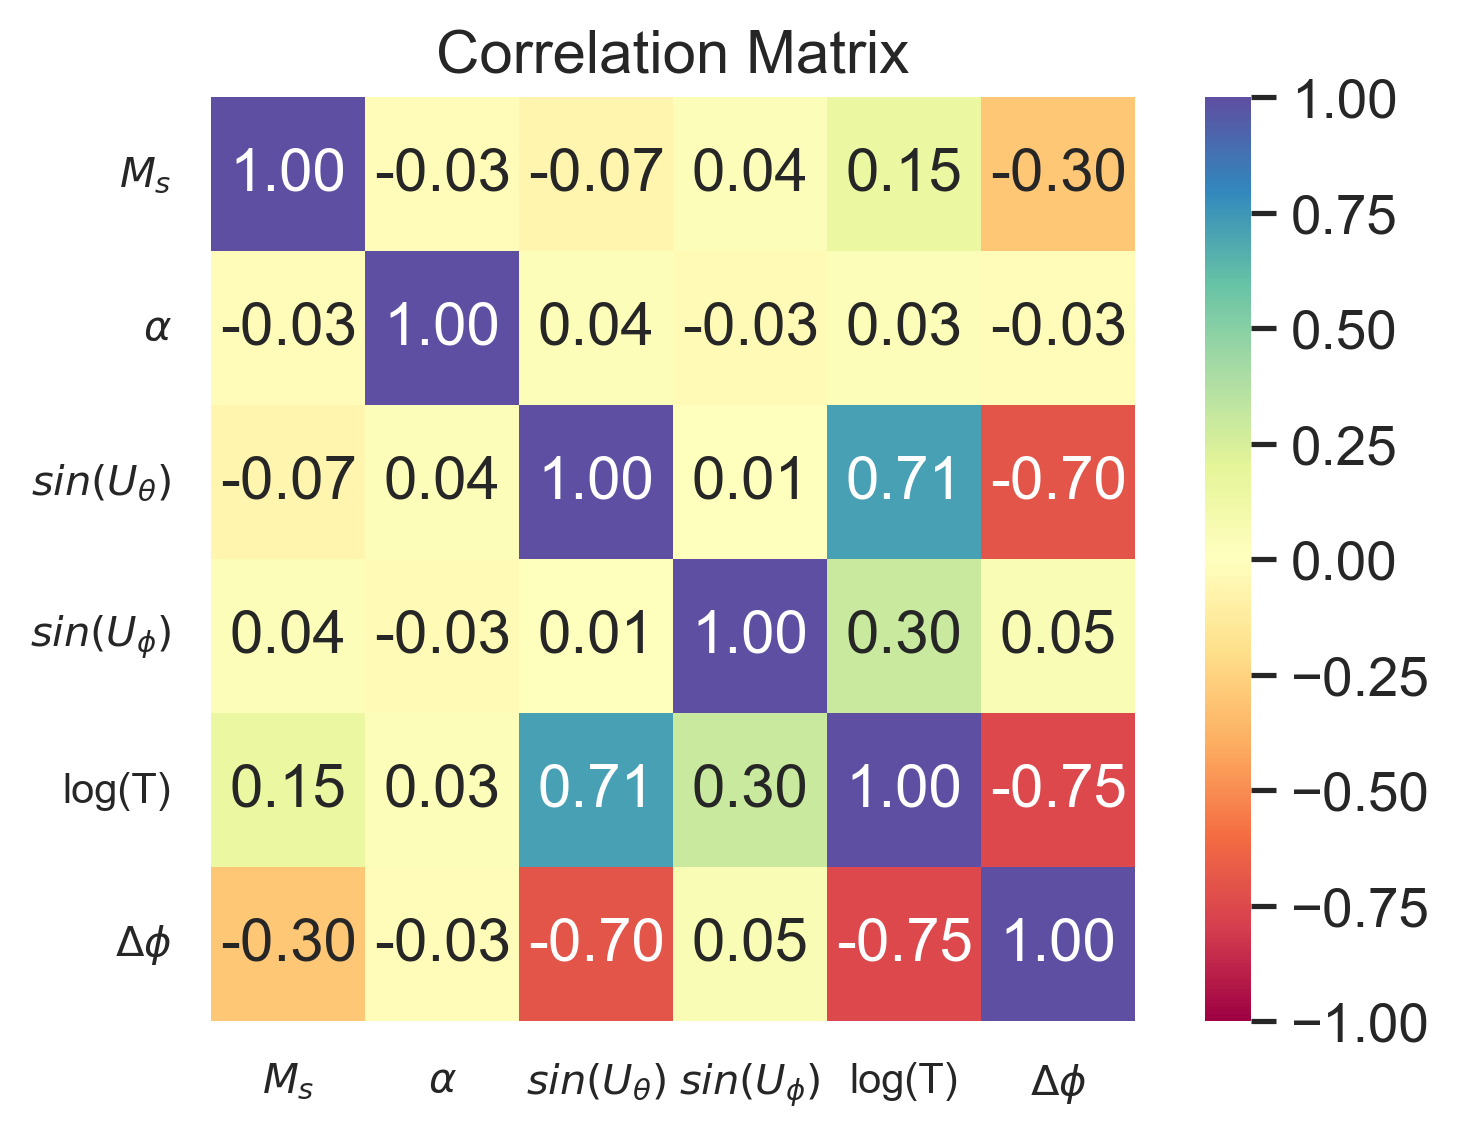

In [17]:
# Load dataset
#df = pd.read_csv("D:\\UBERMAG_RESULTS\\spin_wave_results-two-bounds-lhs-1000.csv")  # Update with the actual filename
df = pd.read_csv("D:\\UBERMAG_RESULTS\\spin_wave_results_LHS_1000_LG2um.csv")  # Update with the actual filename 

# Check basic stats
print(df.info())
print(df.describe())


# Discard raow where T > 1 and TRANSFORM DATA: normalised to the maximum T (i.e. max Ms and lowest alpha)

df = df[df["Transmission"] <= 0.99]
print(np.max(df["Transmission"]))
#df["Transmission"] = df["Transmission"] / np.max(df["Transmission"])

# Transform Phase Shift.


phases_rad = np.deg2rad(df["Phase Shift (deg)"])
mean_phase = np.angle(np.mean(np.exp(1j * phases_rad)))
centered_phases_rad = np.angle(np.exp(1j * (phases_rad - mean_phase)))
df["Phase Shift (deg)"] = np.rad2deg(centered_phases_rad) + 180


# TRANSFORM angle_u to sin(angle_u)


df["angle_theta"] = np.sin(df["angle_theta"] * np.pi / 180)
df.rename(columns={"angle_theta": r"$sin(U_\theta)$"}, inplace=True)

df["angle_phi"] = np.sin(df["angle_phi"] * np.pi / 180)
df.rename(columns={"angle_phi": r"$sin(U_\phi)$"}, inplace=True)

df["Transmission"] = np.log(df["Transmission"])
df.rename(columns={"Transmission": "log(T)"}, inplace=True)

df.rename(columns={"Phase Shift (deg)": r"$\Delta\phi$"}, inplace=True)
df.rename(columns={"M_s": r"$M_s$"}, inplace=True)
df.rename(columns={"alpha": r"$\alpha$"}, inplace=True)

df = df.drop(columns=['A_ex', 'K_u'])
df = df.drop_duplicates()

# df["Phase Shift (deg)"] = np.log(df["Phase Shift (deg)"])
# df.rename(columns={"Phase Shift (deg)": "log(Phase Shift (deg))"}, inplace=True)

# Check basic stats
print(df.info())
print(df.describe())


# Check correlation matrix

fig, ax = plt.subplots(ncols=1, sharey=True)

# plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="Spectral", vmin=-1.00, vmax=1.00, fmt=".2f")
ax.set_box_aspect(1)  # Makes the plot square
ax.tick_params(axis='both', labelsize=10)
plt.title("Correlation Matrix")
plt.show()


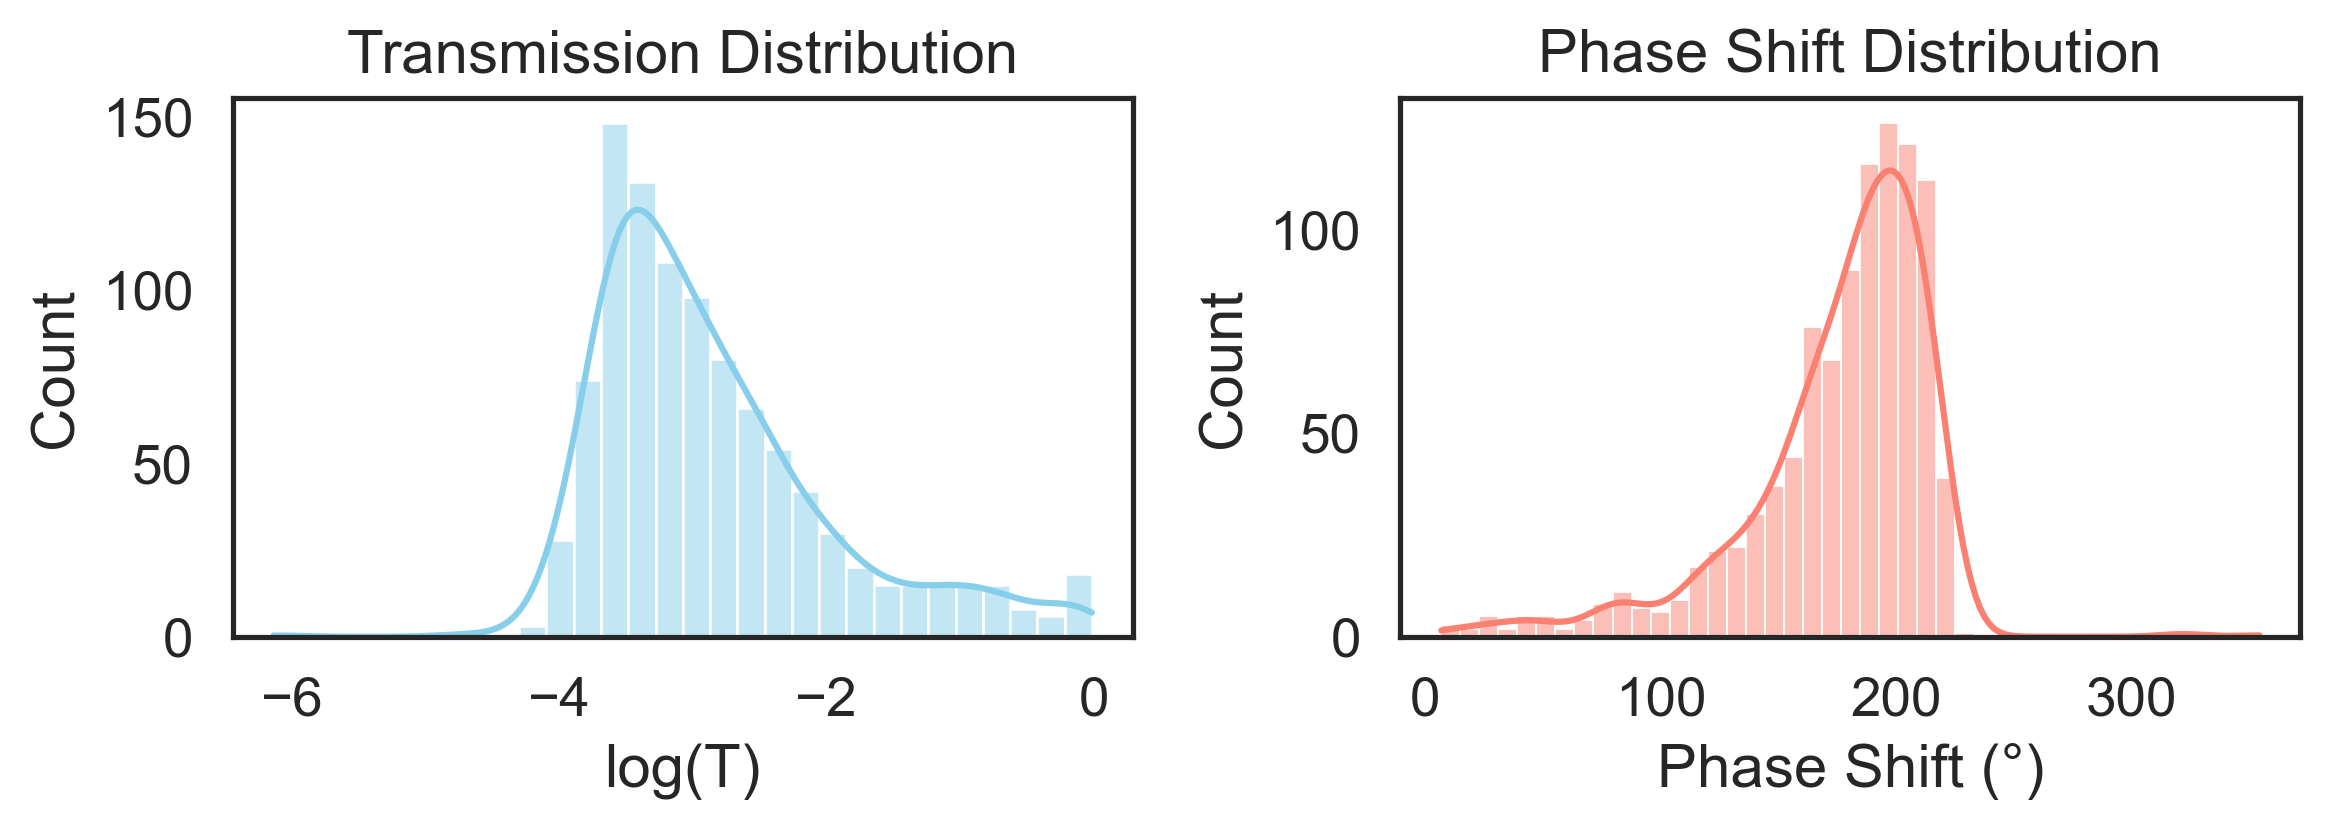

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

sns.histplot(df['log(T)'], kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Transmission Distribution")
axes[0].set_xlabel("log(T)")

sns.histplot(df[r'$\Delta\phi$'], kde=True, ax=axes[1], color="salmon")
axes[1].set_title("Phase Shift Distribution")
axes[1].set_xlabel("Phase Shift (°)")

plt.tight_layout()
plt.show()

In [39]:
seed = 33

C:\Users\david.osuna\AppData\Local\anaconda3\envs\ubermag\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.88          17.3241        5           1.1787           1.0971      3.24m
   1    10.47          2.69391        9         0.630751         0.647363      3.52m
   2    16.65          2.21024       20         0.395039         0.446006      3.63m
   3    18.82          1.88263       20         0.397364         0.425284      4.04m
   4    22.02          1.99577       19         0.387588         0.485778      3.86m
   5    28.81          1.35565       20         0.387504         0.513162      4.81m
   6    27.01          1.99435       59         0.374806         0.529638      4.56m
   7    23.95          1.66286       20         0.373715         0.410475      4.18m
   8    22.06          1.79418       22         0.365069         0.485609  

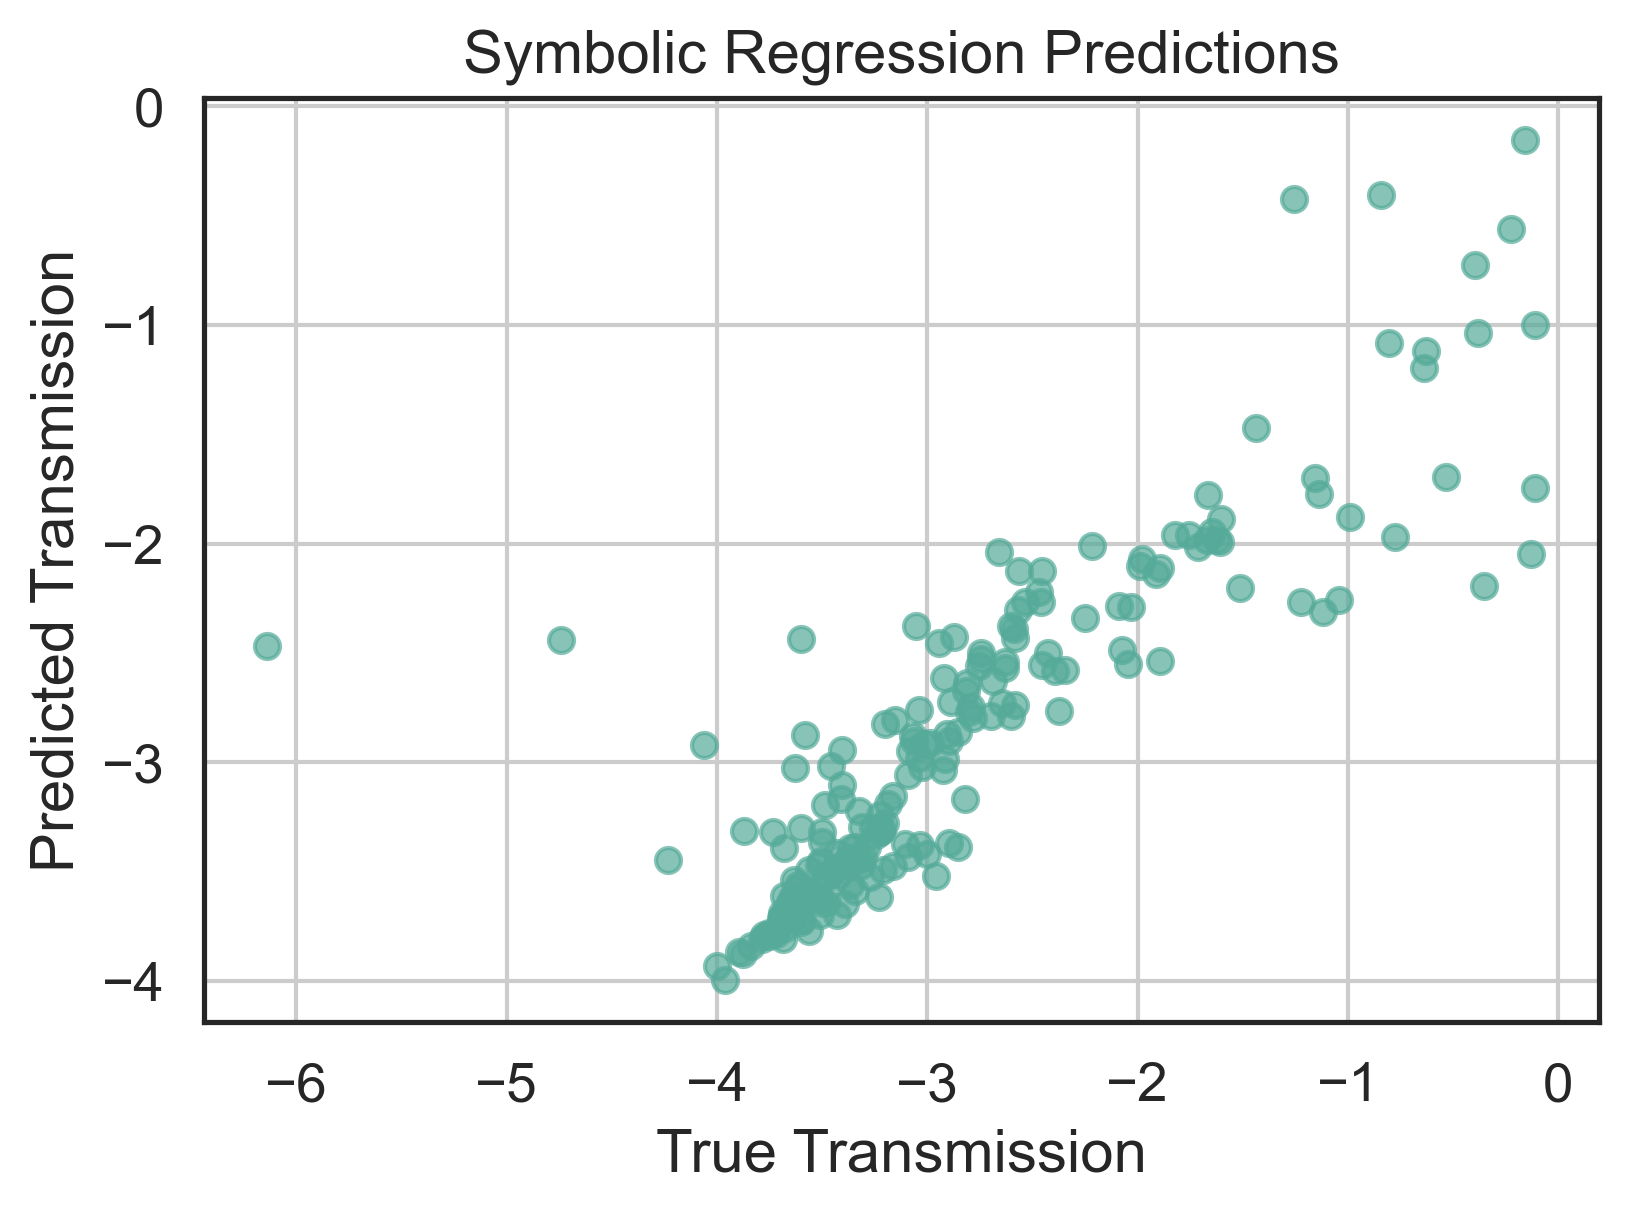

In [28]:
# Choose input (X) and output (y) variables
# Adjust column names depending on your CSV
input_cols = ['$M_s$', r'$\alpha$', r"$sin(U_\theta)$", r"$sin(U_\phi)$"]  # example input columns
output_col_trans = 'log(T)'             # change to actual column name
output_col_phase = r'$\Delta\phi$'              # change to actual column name

X = df[input_cols].values
y_trans = df[output_col_trans].values
y_phase = df[output_col_phase].values

# Scale inputs (optional but helpful)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)




# X, y = h.columns.tolist(return_X_y=True)  # Dataset for testing the model
# Split dataset
X_train, X_test, y_train_T, y_test_T = train_test_split(X_scaled, y_trans, test_size=0.2, random_state=42)

# Symbolic Regressor
model_T = SymbolicRegressor(
    population_size=3000,
    generations=100,
    stopping_criteria=0.001,
    function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'cos', 'abs', 'neg'], # This can improve modeling flexibility. Especially abs and neg can help in symmetric or oscillating systems like spin waves.
    parsimony_coefficient=0.001,   # Este coeficiente, si alto, puede penalizar demasiado la complejidad del modelo (regularization): antes 0.001
    max_samples=0.9,  # esto antes era 1.0, se reduce para subsamplear
    verbose=1,
    random_state=seed,
    feature_names=input_cols # input_cols
)

# Fit model
model_T.fit(X_train, y_train_T)

# Show the symbolic expression
print("Symbolic expression for transmission:")
print(model_T._program)

# Predict and compare
y_pred_T = model_T.predict(X_test)

# Plot predictions vs true
plt.scatter(y_test_T, y_pred_T, alpha=0.7)
plt.xlabel("True Transmission")
plt.ylabel("Predicted Transmission")
plt.title("Symbolic Regression Predictions")
plt.grid(True)
plt.show()

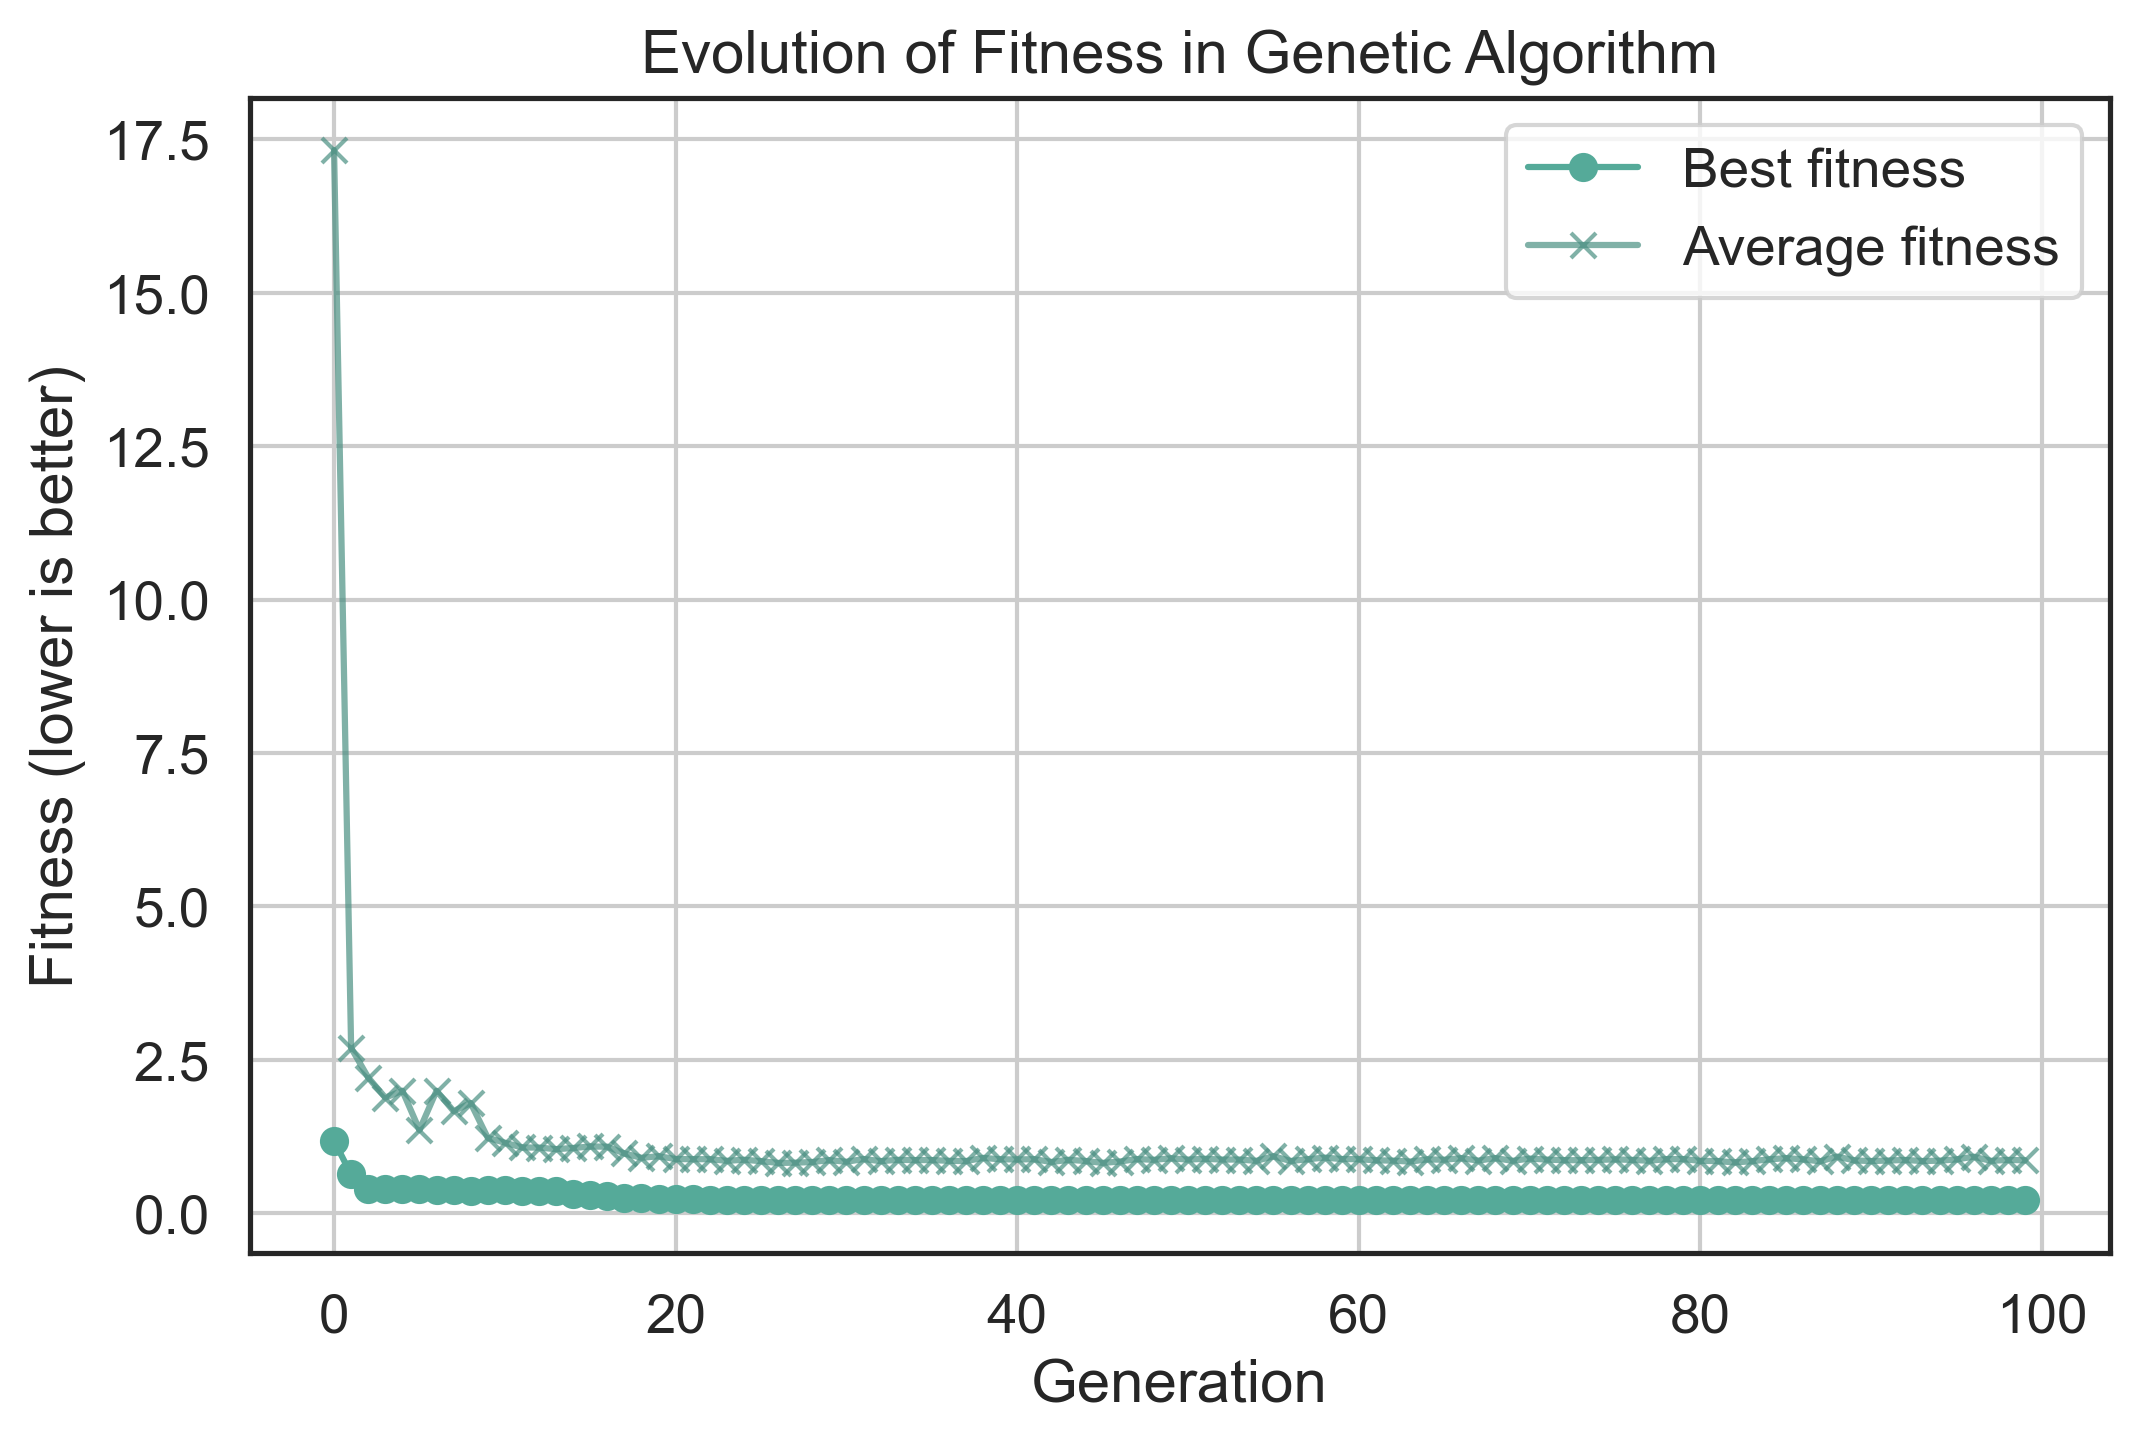

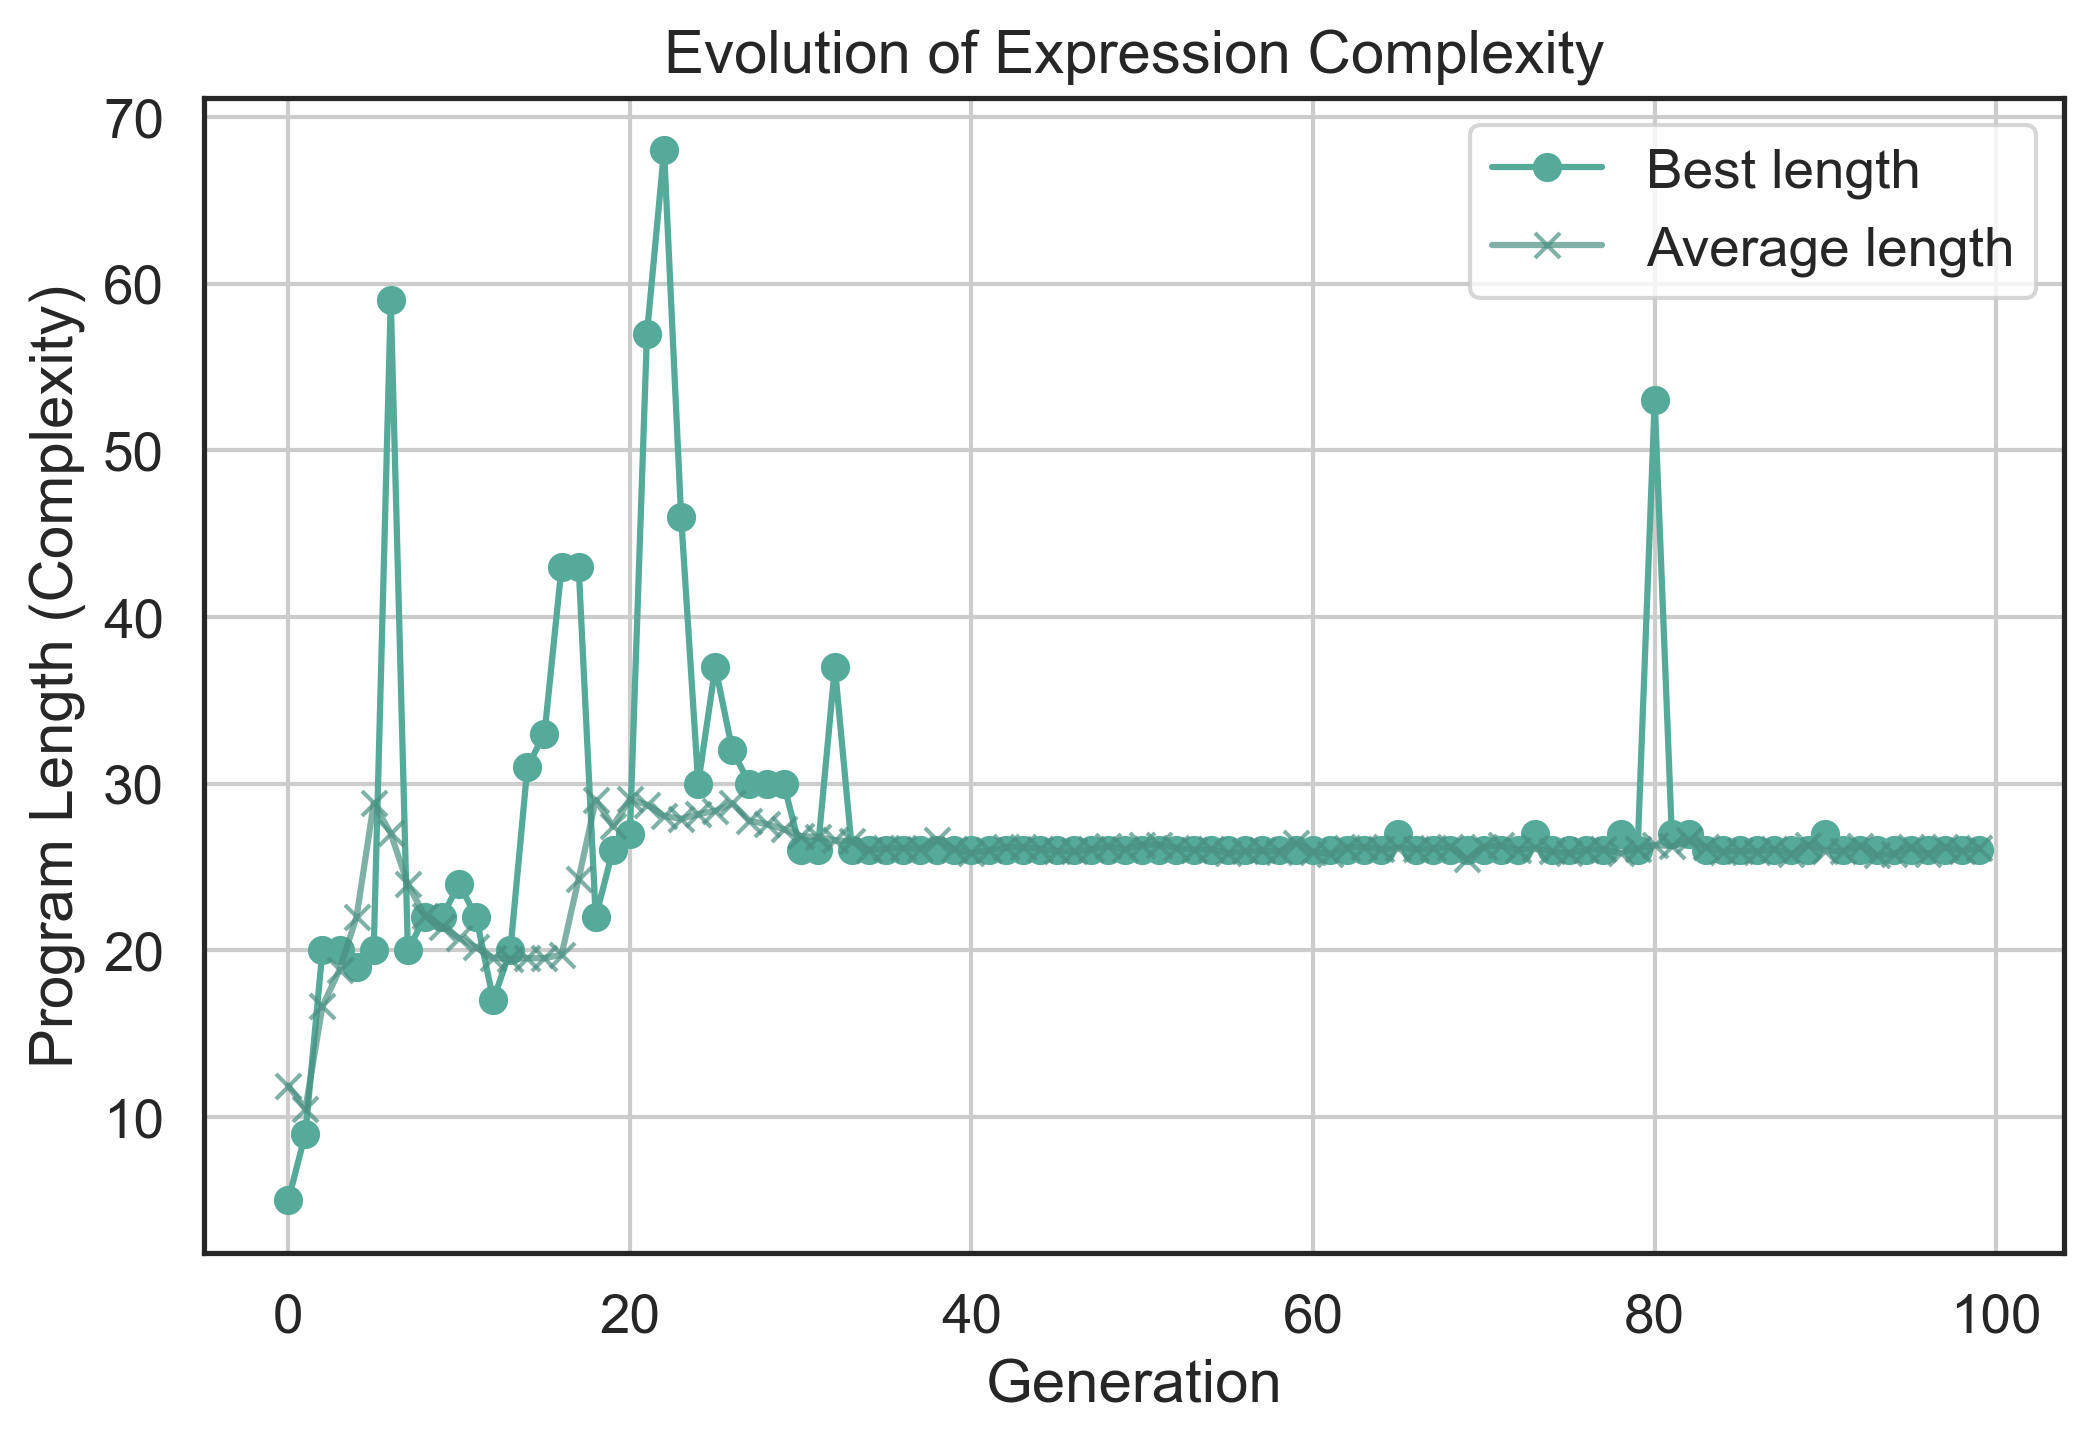

Symbolic expression for transmission:
div(sqrt(add(add(neg($sin(U_\theta)$), sqrt(add($sin(U_\phi)$, add(div(sqrt(add(add($M_s$, add(neg($sin(U_\theta)$), -0.987)), sqrt(0.782))), -0.504), -0.987)))), cos($sin(U_\theta)$))), -0.504)
Test MAE: 0.2898


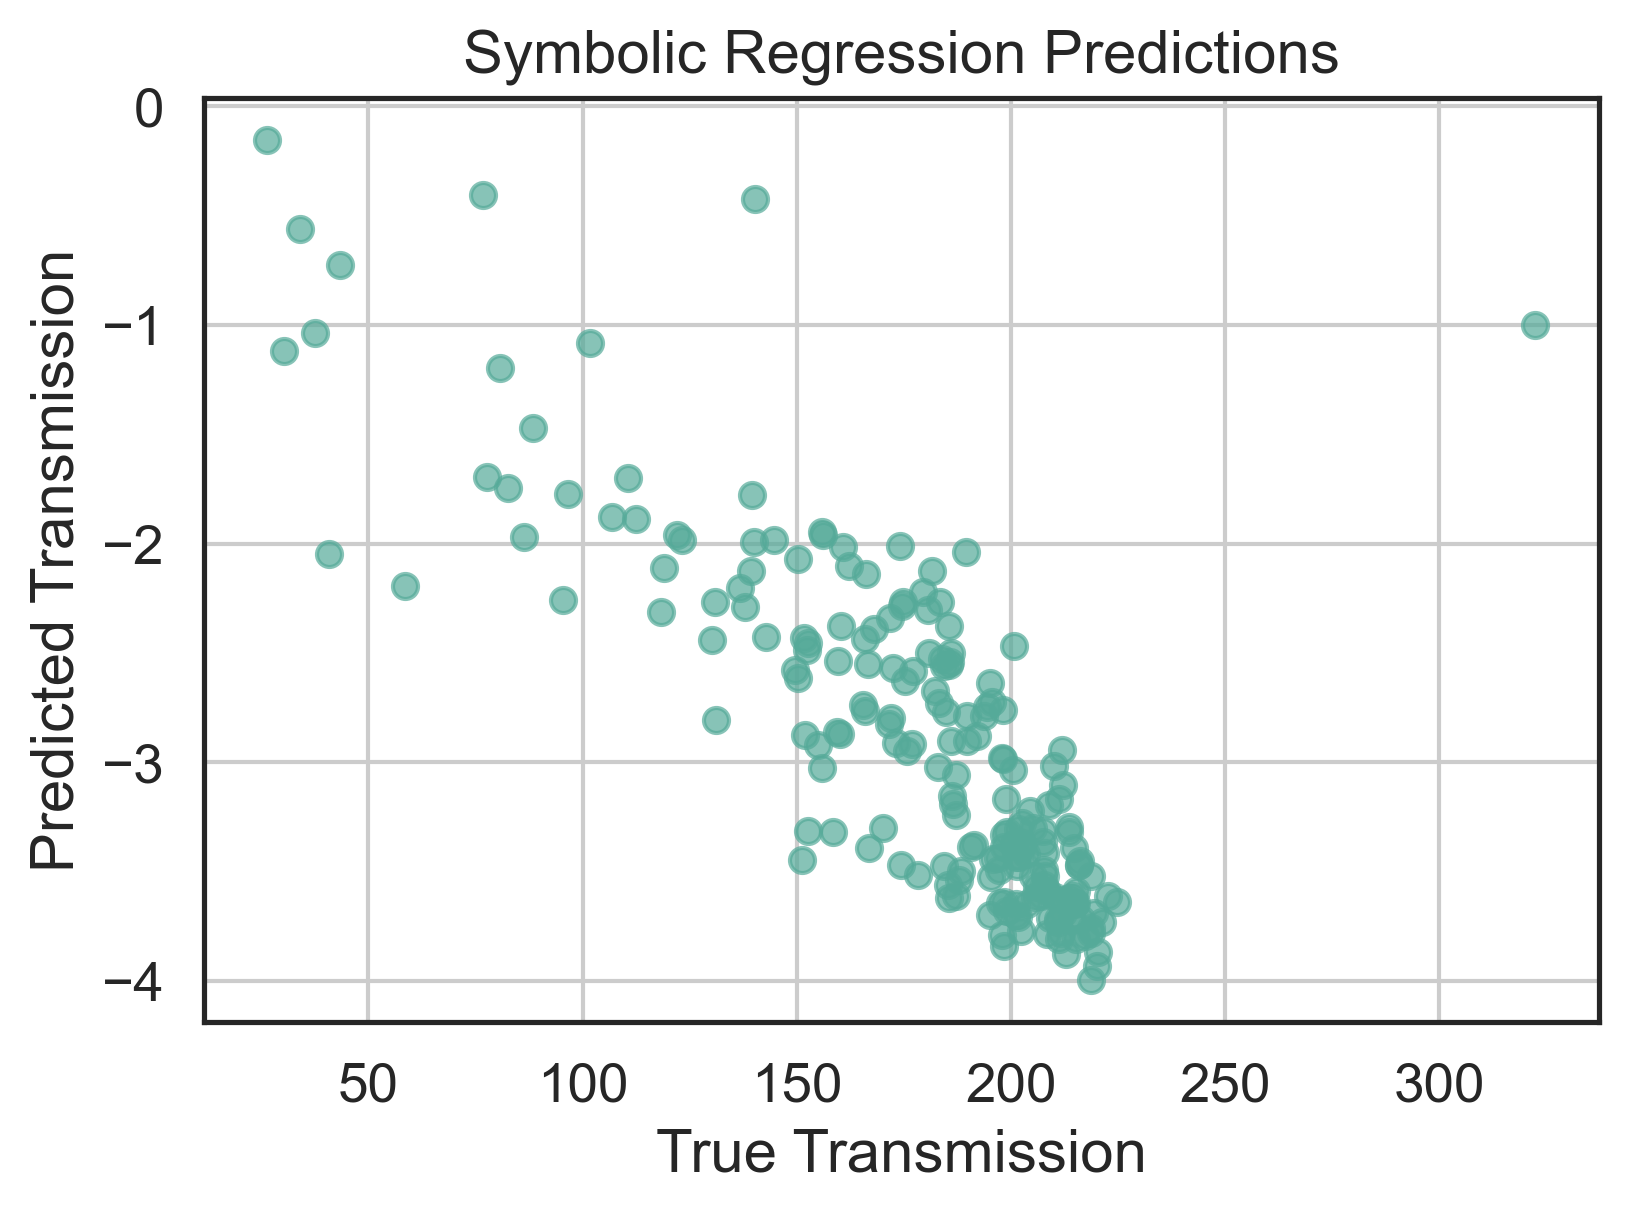

In [29]:
history_T = pd.DataFrame(model_T.run_details_)
# -------- Plot 1: Fitness Evolution --------
plt.figure(figsize=(8,5))
plt.plot(history_T['generation'], history_T['best_fitness'], marker='o', label='Best fitness')
plt.plot(history_T['generation'], history_T['average_fitness'], marker='x', label='Average fitness', alpha=0.7)
plt.xlabel("Generation")
plt.ylabel("Fitness (lower is better)")
plt.title("Evolution of Fitness in Genetic Algorithm")
plt.legend()
plt.grid(True)
plt.show()

# -------- Plot 2: Complexity Evolution --------
plt.figure(figsize=(8,5))
plt.plot(history_T['generation'], history_T['best_length'], marker='o', label='Best length')
plt.plot(history_T['generation'], history_T['average_length'], marker='x', label='Average length', alpha=0.7)
plt.xlabel("Generation")
plt.ylabel("Program Length (Complexity)")
plt.title("Evolution of Expression Complexity")
plt.legend()
plt.grid(True)
plt.show()

# -------- Show symbolic expression --------
print("Symbolic expression for transmission:")
print(model_T._program)

# -------- Predict & Evaluate --------
y_pred = model_T.predict(X_test)
mae = mean_absolute_error(y_test_T, y_pred_T)
print(f"Test MAE: {mae:.4f}")

# -------- Plot predictions vs. true values --------
plt.scatter(y_test_T, y_pred_T, alpha=0.7)
plt.xlabel("True Transmission")
plt.ylabel("Predicted Transmission")
plt.title("Symbolic Regression Predictions")
plt.grid(True)
plt.show()

C:\Users\david.osuna\AppData\Local\anaconda3\envs\ubermag\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    13.81          182.519       87           169.09           172.32      1.16m
   1     9.85          175.138       93          167.361          167.865      1.46m
   2    18.06          173.114       27          136.306          120.134      1.34m
   3    17.97          169.958       12          73.5604          72.3934      1.27m
   4    19.21          199.896       15          34.0284          35.0186      1.34m
   5    23.42          300.789       18          27.1384          25.3704      1.49m
   6    24.99          375.581       14          26.0372          36.0085      1.73m
   7    24.70          431.088       26          26.1802          33.6103      1.79m
   8    23.35          291.025       19          23.1436          23.3422  

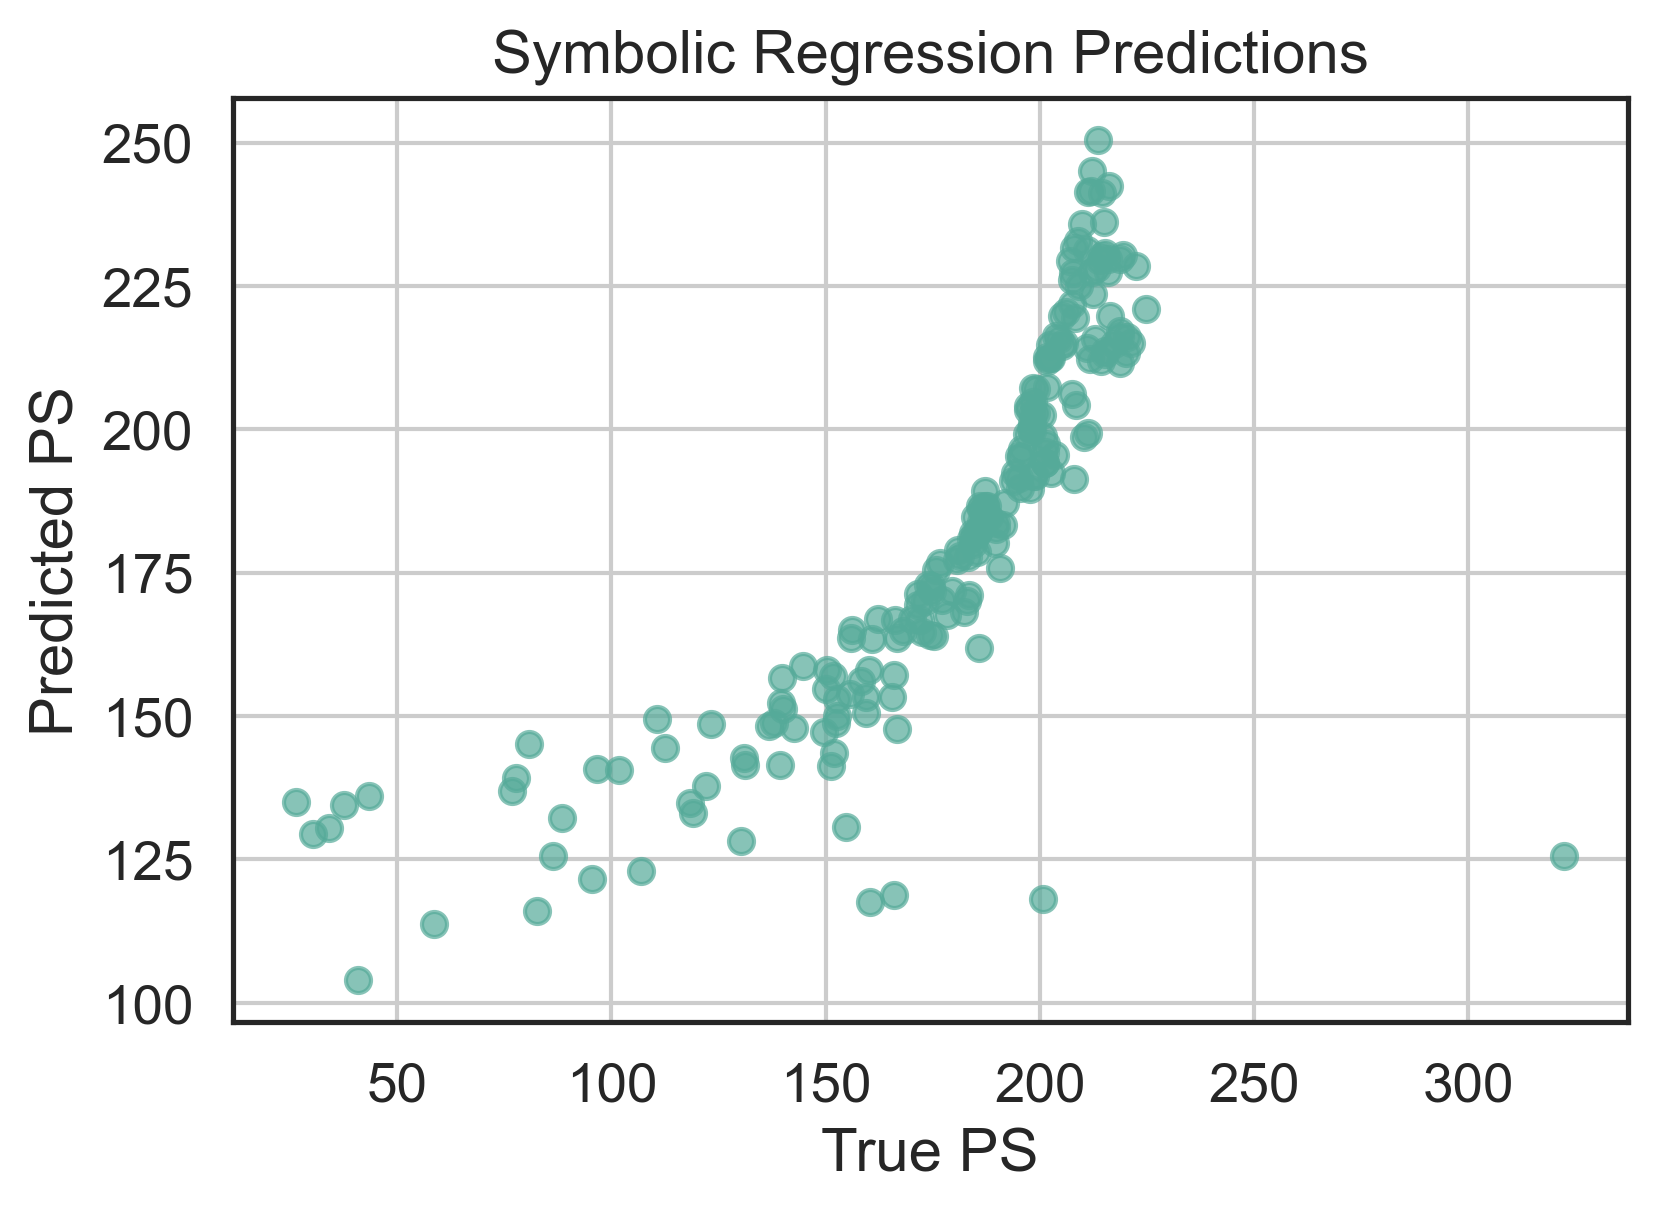

In [40]:
# Choose input (X) and output (y) variables
# Adjust column names depending on your CSV
input_cols = ['$M_s$', r'$\alpha$', r"$sin(U_\theta)$", r"$sin(U_\phi)$"]  # example input columns
output_col_trans = 'log(T)'             # change to actual column name
output_col_phase = r'$\Delta\phi$'               # change to actual column name

X = df[input_cols].values
y_trans = df[output_col_trans].values
y_phase = df[output_col_phase].values

# Scale inputs (optional but helpful)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train_P, y_test_P = train_test_split(X_scaled, y_phase, test_size=0.2, random_state=42)

# Symbolic Regressor
model_P = SymbolicRegressor(
    population_size=1000,
    generations=100,
    stopping_criteria=0.001,
    function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'cos', 'neg'], # This can improve modeling flexibility. Especially abs and neg can help in symmetric or oscillating systems like spin waves.
    parsimony_coefficient=0.05,   # Este coeficiente, si alto, puede penalizar demasiado la complejidad del modelo (regularization): antes 0.001
    max_samples=0.9,  # esto antes era 1.0, se reduce para subsamplear
    verbose=1,
    random_state=seed,
    feature_names=input_cols
)

# Fit model
model_P.fit(X_train, y_train)

# Show the symbolic expression
print("Symbolic expression for Phase shift:")
print(model_P._program)

# Predict and compare
y_pred_P = model_P.predict(X_test)

# Plot predictions vs true
plt.scatter(y_test_P, y_pred_P, alpha=0.7)
plt.xlabel("True PS")
plt.ylabel("Predicted PS")
plt.title("Symbolic Regression Predictions")
plt.grid(True)
plt.show()

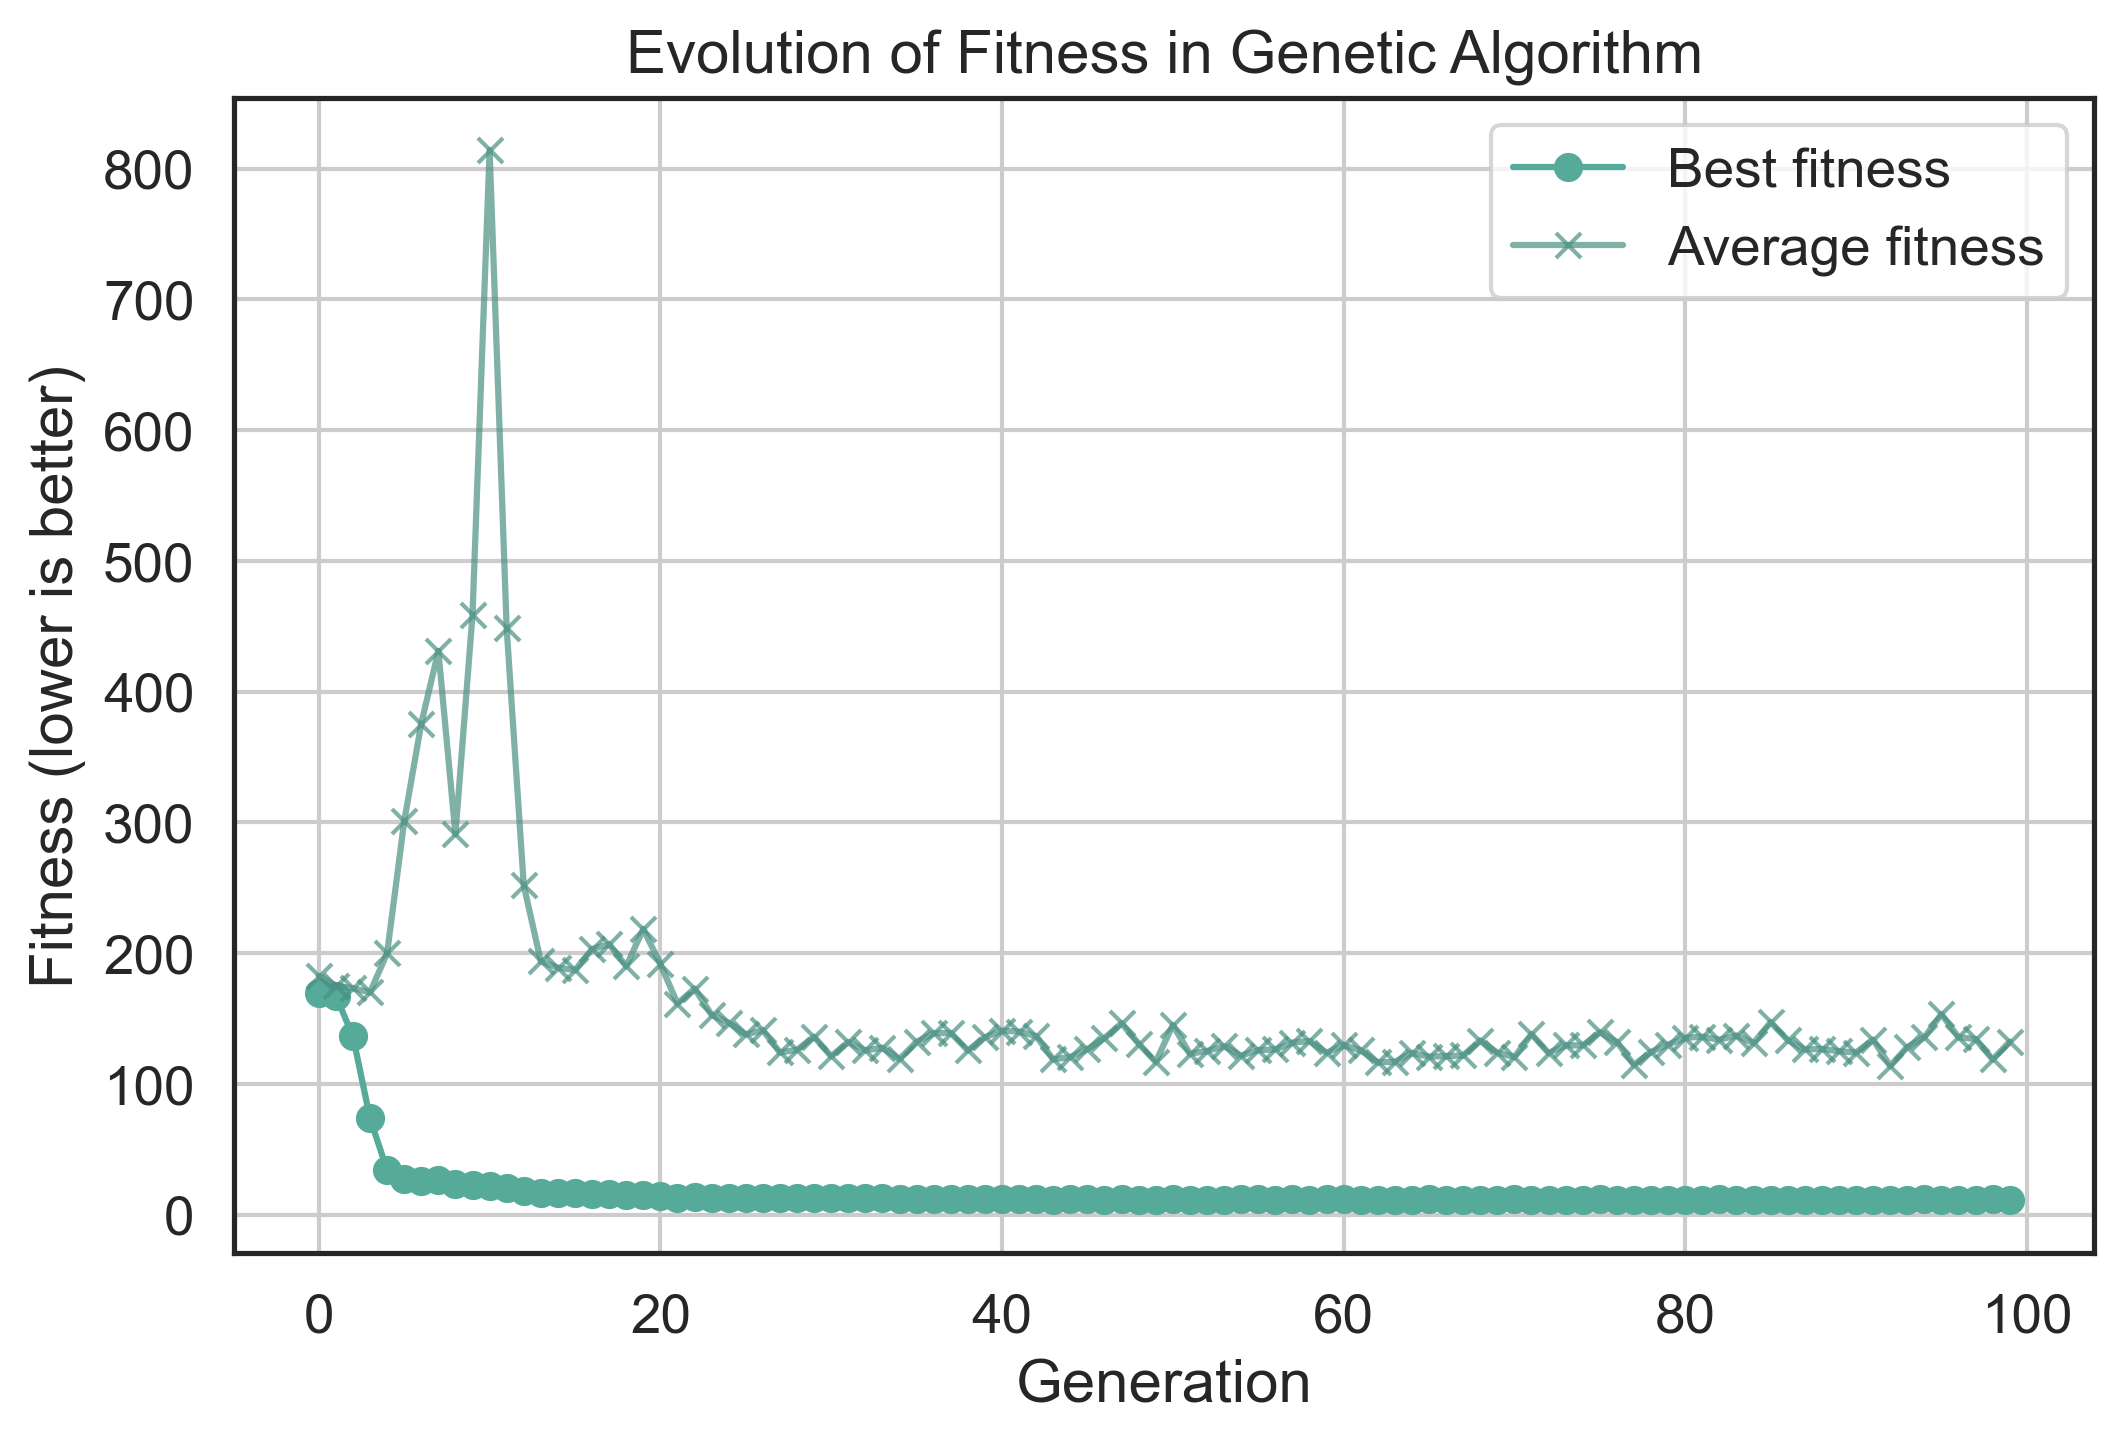

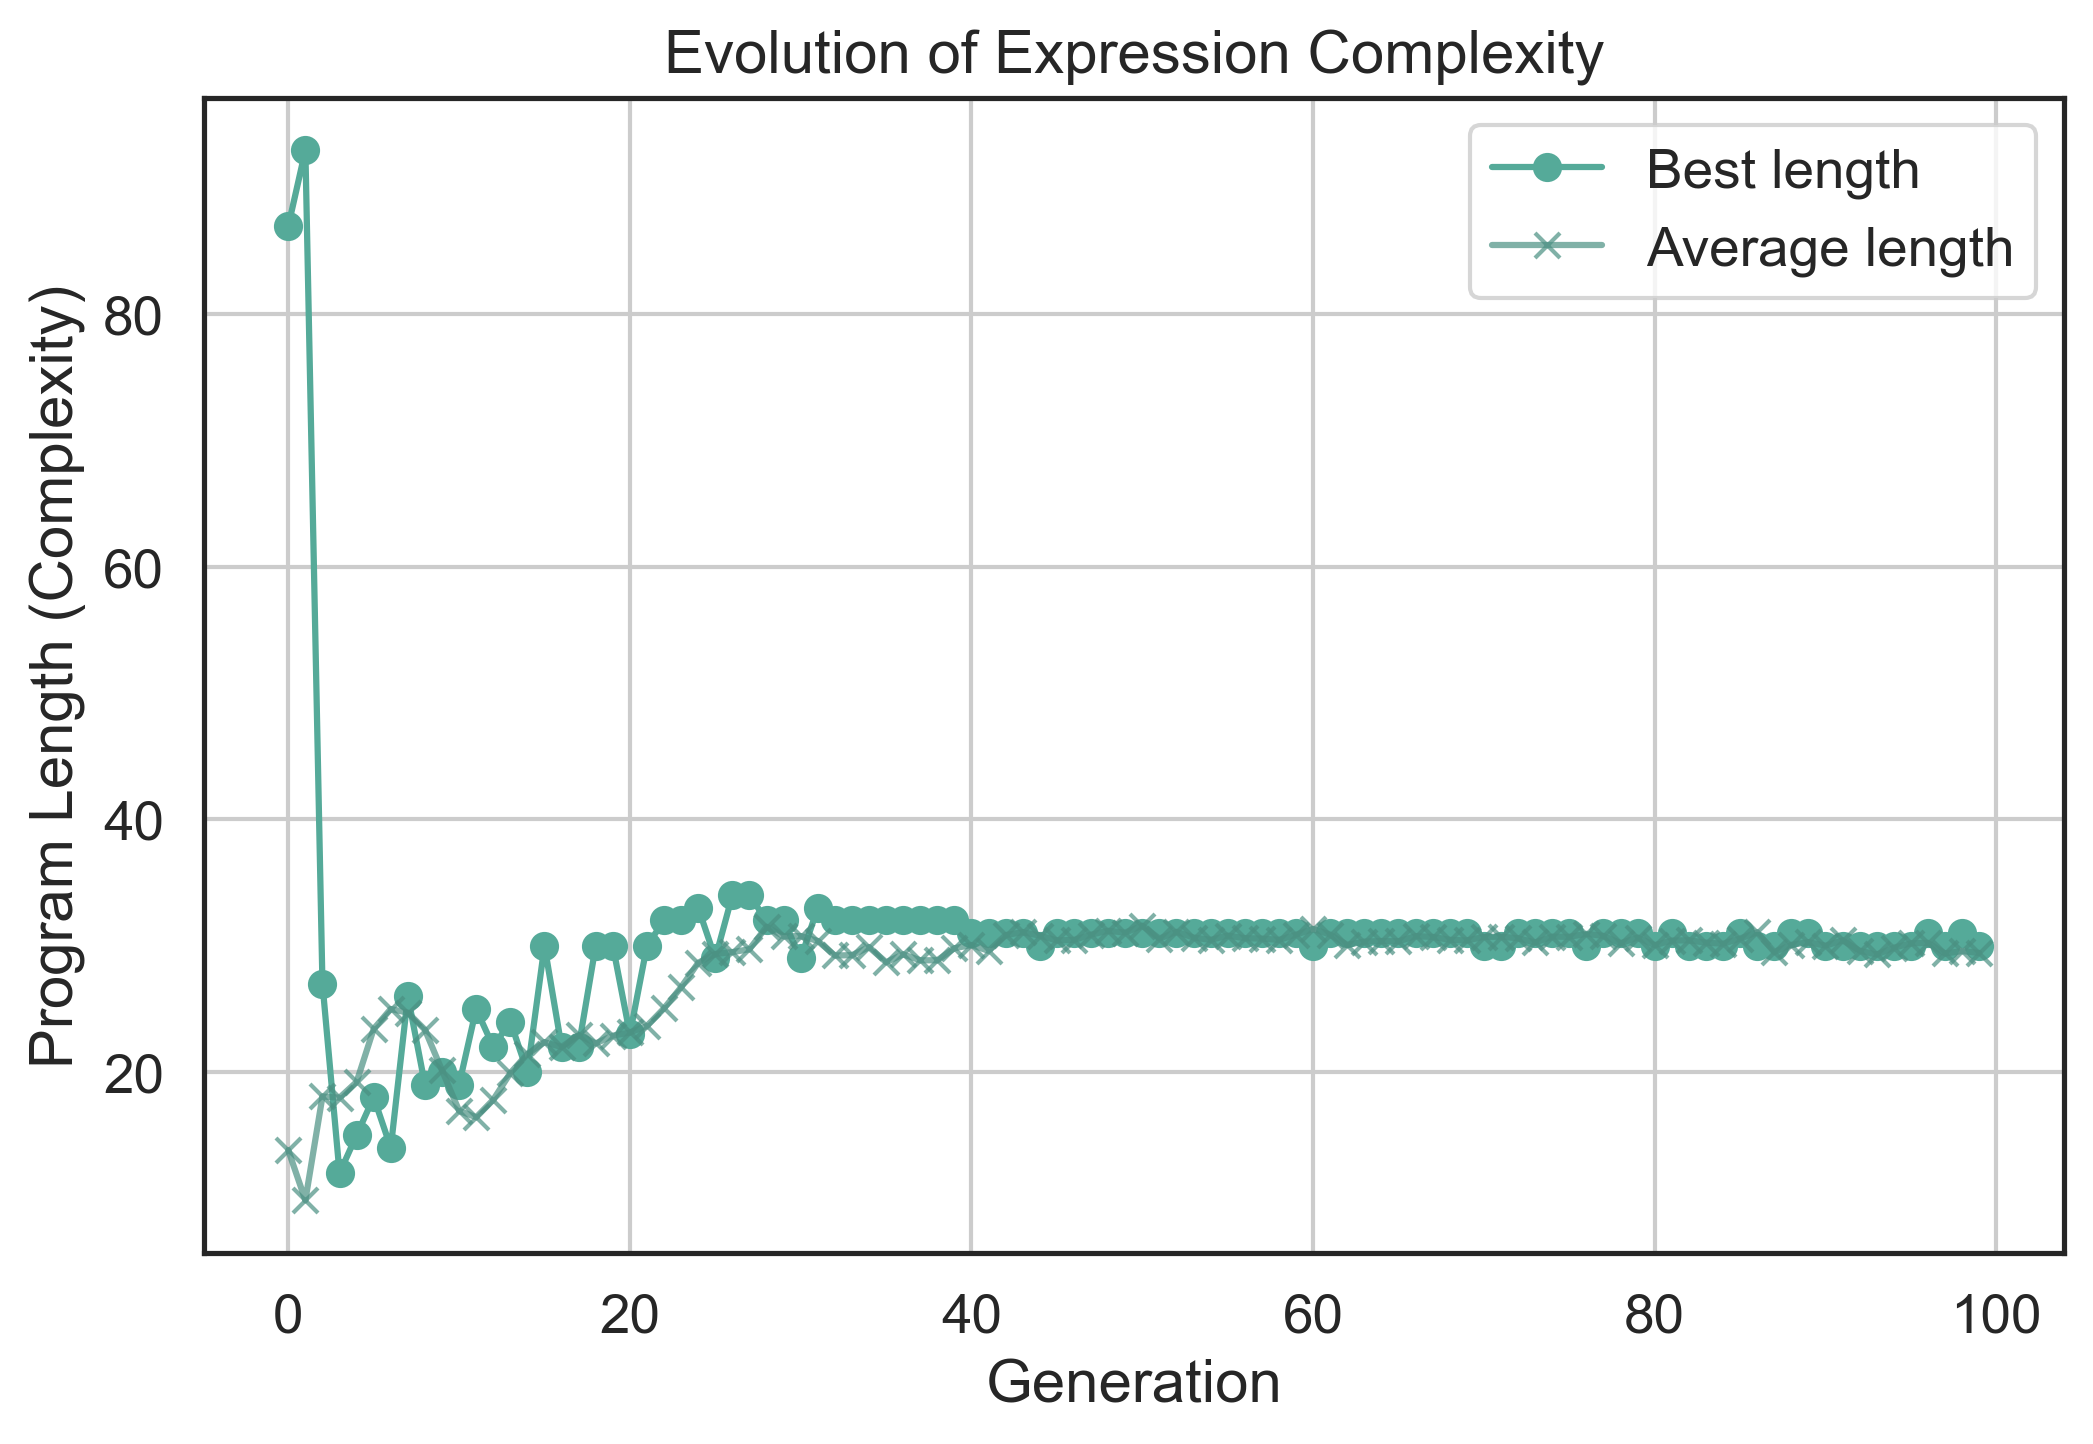

Symbolic expression for Phase Shift:
div(div(sqrt(div(sub(add(sub(sub(add(sub(div(div(0.910, 0.224), 0.290), $sin(U_\theta)$), $sin(U_\phi)$), $sin(U_\theta)$), $sin(U_\theta)$), sub(sub(-0.587, $M_s$), $M_s$)), $sin(U_\theta)$), 0.290)), 0.224), add(-0.587, 0.753))
Test MAE: 14.9387


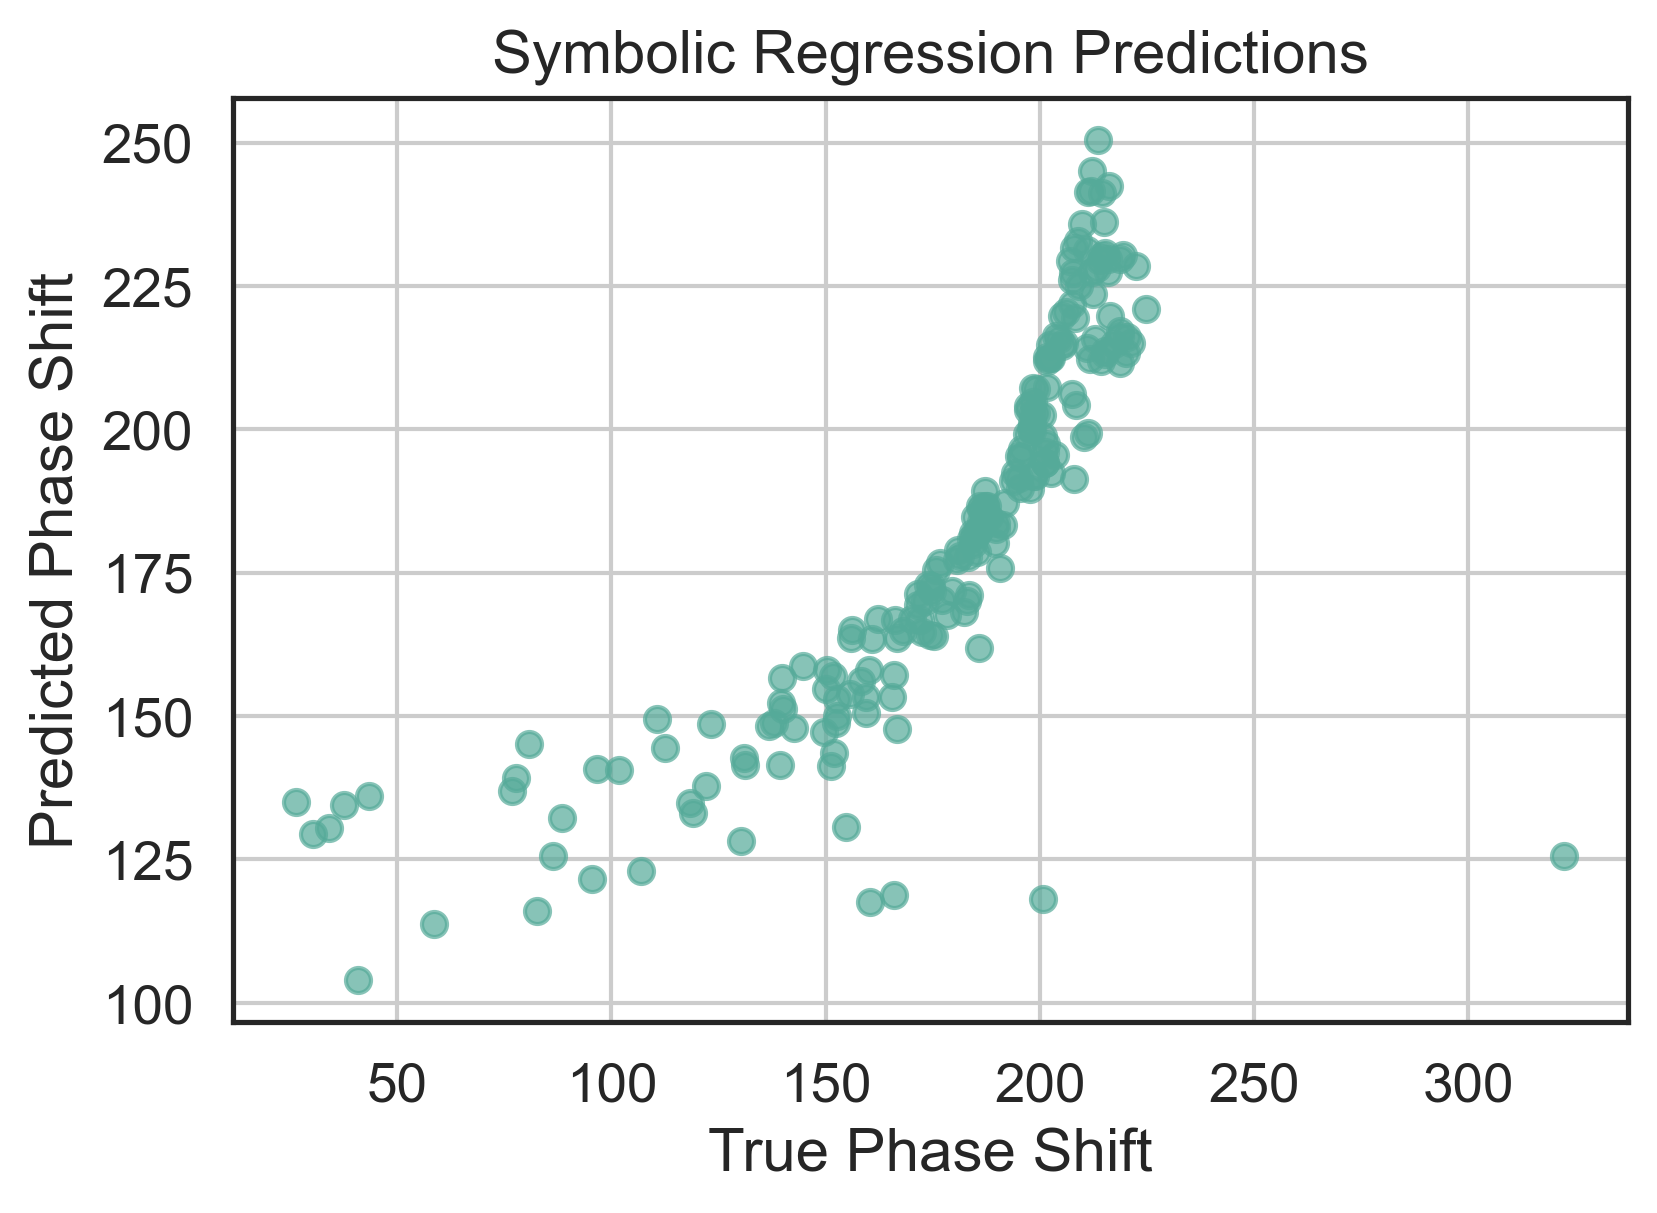

In [41]:
history_P = pd.DataFrame(model_P.run_details_)
# -------- Plot 1: Fitness Evolution --------
plt.figure(figsize=(8,5))
plt.plot(history_P['generation'], history_P['best_fitness'], marker='o', label='Best fitness')
plt.plot(history_P['generation'], history_P['average_fitness'], marker='x', label='Average fitness', alpha=0.7)
plt.xlabel("Generation")
plt.ylabel("Fitness (lower is better)")
plt.title("Evolution of Fitness in Genetic Algorithm")
plt.legend()
plt.grid(True)
plt.show()

# -------- Plot 2: Complexity Evolution --------
plt.figure(figsize=(8,5))
plt.plot(history_P['generation'], history_P['best_length'], marker='o', label='Best length')
plt.plot(history_P['generation'], history_P['average_length'], marker='x', label='Average length', alpha=0.7)
plt.xlabel("Generation")
plt.ylabel("Program Length (Complexity)")
plt.title("Evolution of Expression Complexity")
plt.legend()
plt.grid(True)
plt.show()

# -------- Show symbolic expression --------
print("Symbolic expression for Phase Shift:")
print(model_P._program)

# -------- Predict & Evaluate --------
y_pred_P = model_P.predict(X_test)
mae = mean_absolute_error(y_test_P, y_pred_P)
print(f"Test MAE: {mae:.4f}")

# -------- Plot predictions vs. true values --------
plt.scatter(y_test_P, y_pred_P, alpha=0.7)
plt.xlabel("True Phase Shift")
plt.ylabel("Predicted Phase Shift")
plt.title("Symbolic Regression Predictions")
plt.grid(True)
plt.show()

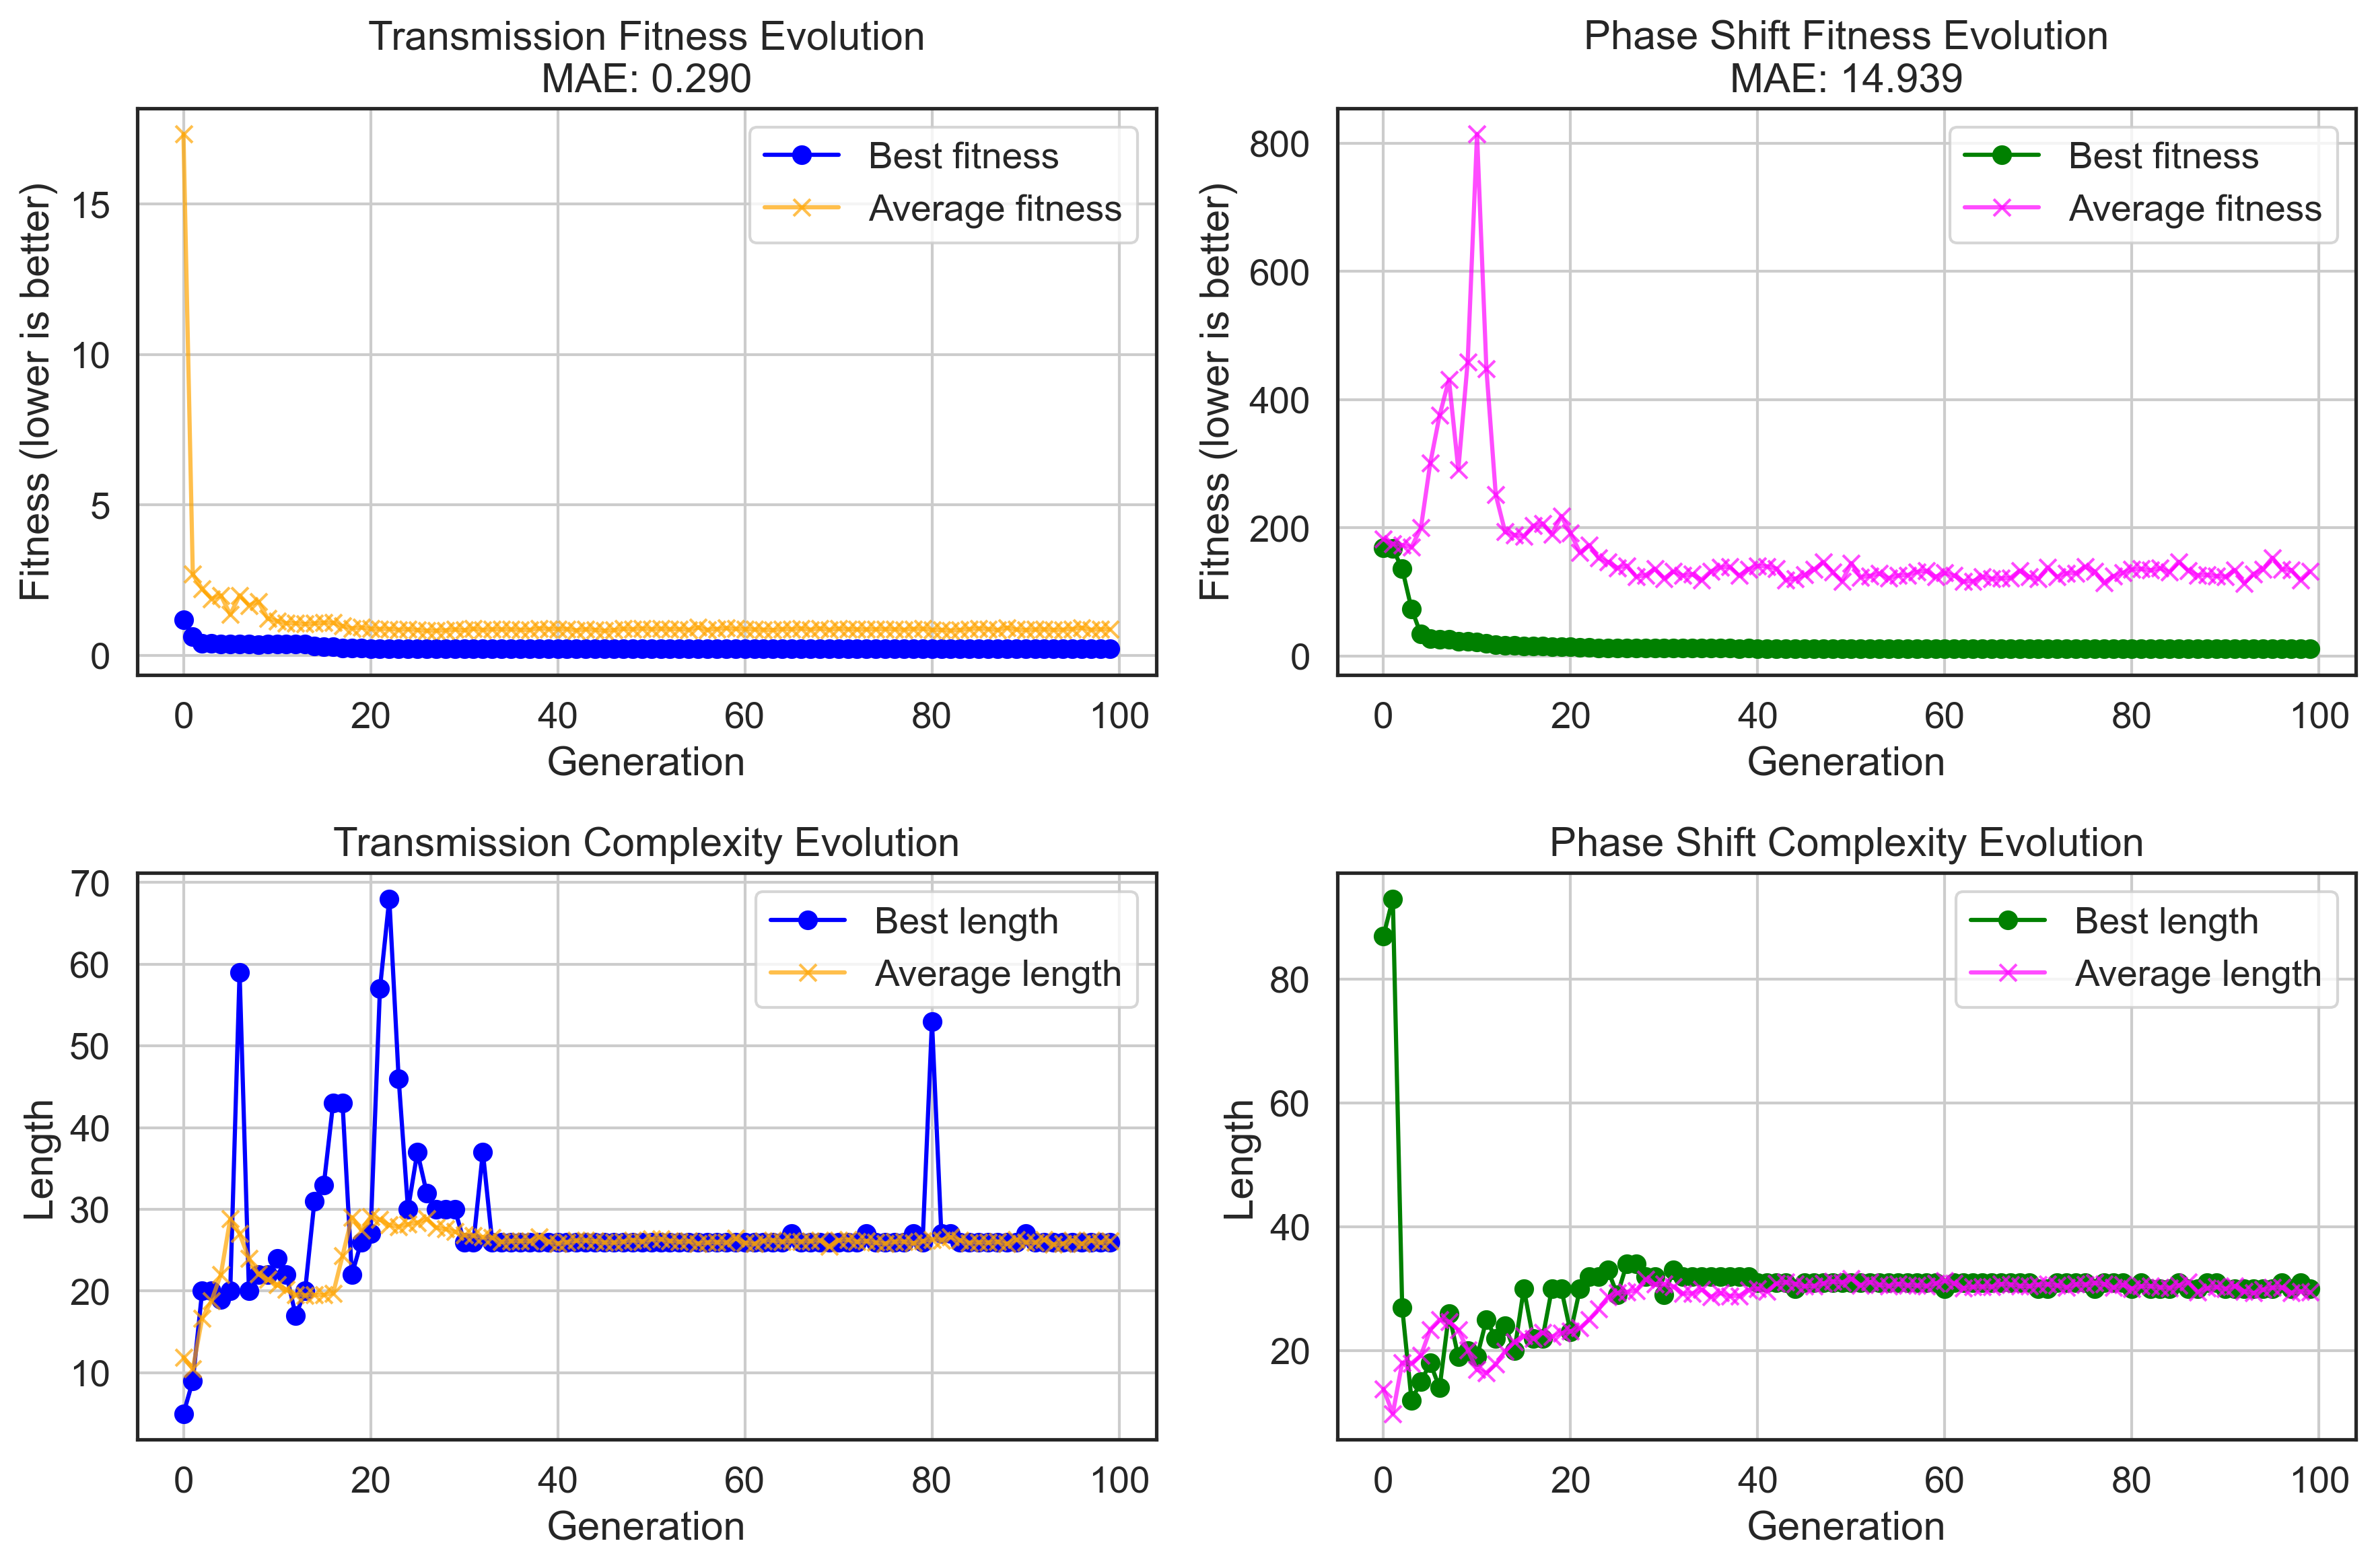

In [42]:
# Extract history for both models
history_T = pd.DataFrame(model_T.run_details_)
history_P = pd.DataFrame(model_P.run_details_)

# Predict and compute MAE for both
y_pred_T = model_T.predict(X_test)
mae_T = mean_absolute_error(y_test_T, y_pred_T)

y_pred_P = model_P.predict(X_test)
mae_P = mean_absolute_error(y_test_P, y_pred_P)

# --- Create figure ---
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# === Plot 1a: Fitness Evolution for T ===
axs[0, 0].plot(history_T['generation'], history_T['best_fitness'], marker='o', label='Best fitness', color='blue')
axs[0, 0].plot(history_T['generation'], history_T['average_fitness'], marker='x', alpha=0.7, label='Average fitness', color='orange')
axs[0, 0].set_title(f"Transmission Fitness Evolution\nMAE: {mae_T:.3f}")
axs[0, 0].set_xlabel("Generation")
axs[0, 0].set_ylabel("Fitness (lower is better)")
axs[0, 0].legend()
axs[0, 0].grid(True)

# === Plot 1b: Complexity Evolution for T ===
axs[1, 0].plot(history_T['generation'], history_T['best_length'], marker='o', label='Best length', color='blue')
axs[1, 0].plot(history_T['generation'], history_T['average_length'], marker='x', alpha=0.7, label='Average length', color='orange')
axs[1, 0].set_title("Transmission Complexity Evolution")
axs[1, 0].set_xlabel("Generation")
axs[1, 0].set_ylabel("Length")
axs[1, 0].legend()
axs[1, 0].grid(True)

# === Plot 2a: Fitness Evolution for P ===
axs[0, 1].plot(history_P['generation'], history_P['best_fitness'], marker='o', label='Best fitness', color='green')
axs[0, 1].plot(history_P['generation'], history_P['average_fitness'], marker='x', alpha=0.7, label='Average fitness', color='magenta')
axs[0, 1].set_title(f"Phase Shift Fitness Evolution\nMAE: {mae_P:.3f}")
axs[0, 1].set_xlabel("Generation")
axs[0, 1].set_ylabel("Fitness (lower is better)")
axs[0, 1].legend()
axs[0, 1].grid(True)

# === Plot 2b: Complexity Evolution for P ===
axs[1, 1].plot(history_P['generation'], history_P['best_length'], marker='o', label='Best length', color='green')
axs[1, 1].plot(history_P['generation'], history_P['average_length'], marker='x', alpha=0.7, label='Average length', color='magenta')
axs[1, 1].set_title("Phase Shift Complexity Evolution")
axs[1, 1].set_xlabel("Generation")
axs[1, 1].set_ylabel("Length")
axs[1, 1].legend()
axs[1, 1].grid(True)

# --- Layout and Save ---
plt.tight_layout()
plt.savefig("SR_fitness_complexity_evolution.pdf", format='pdf')
plt.show()


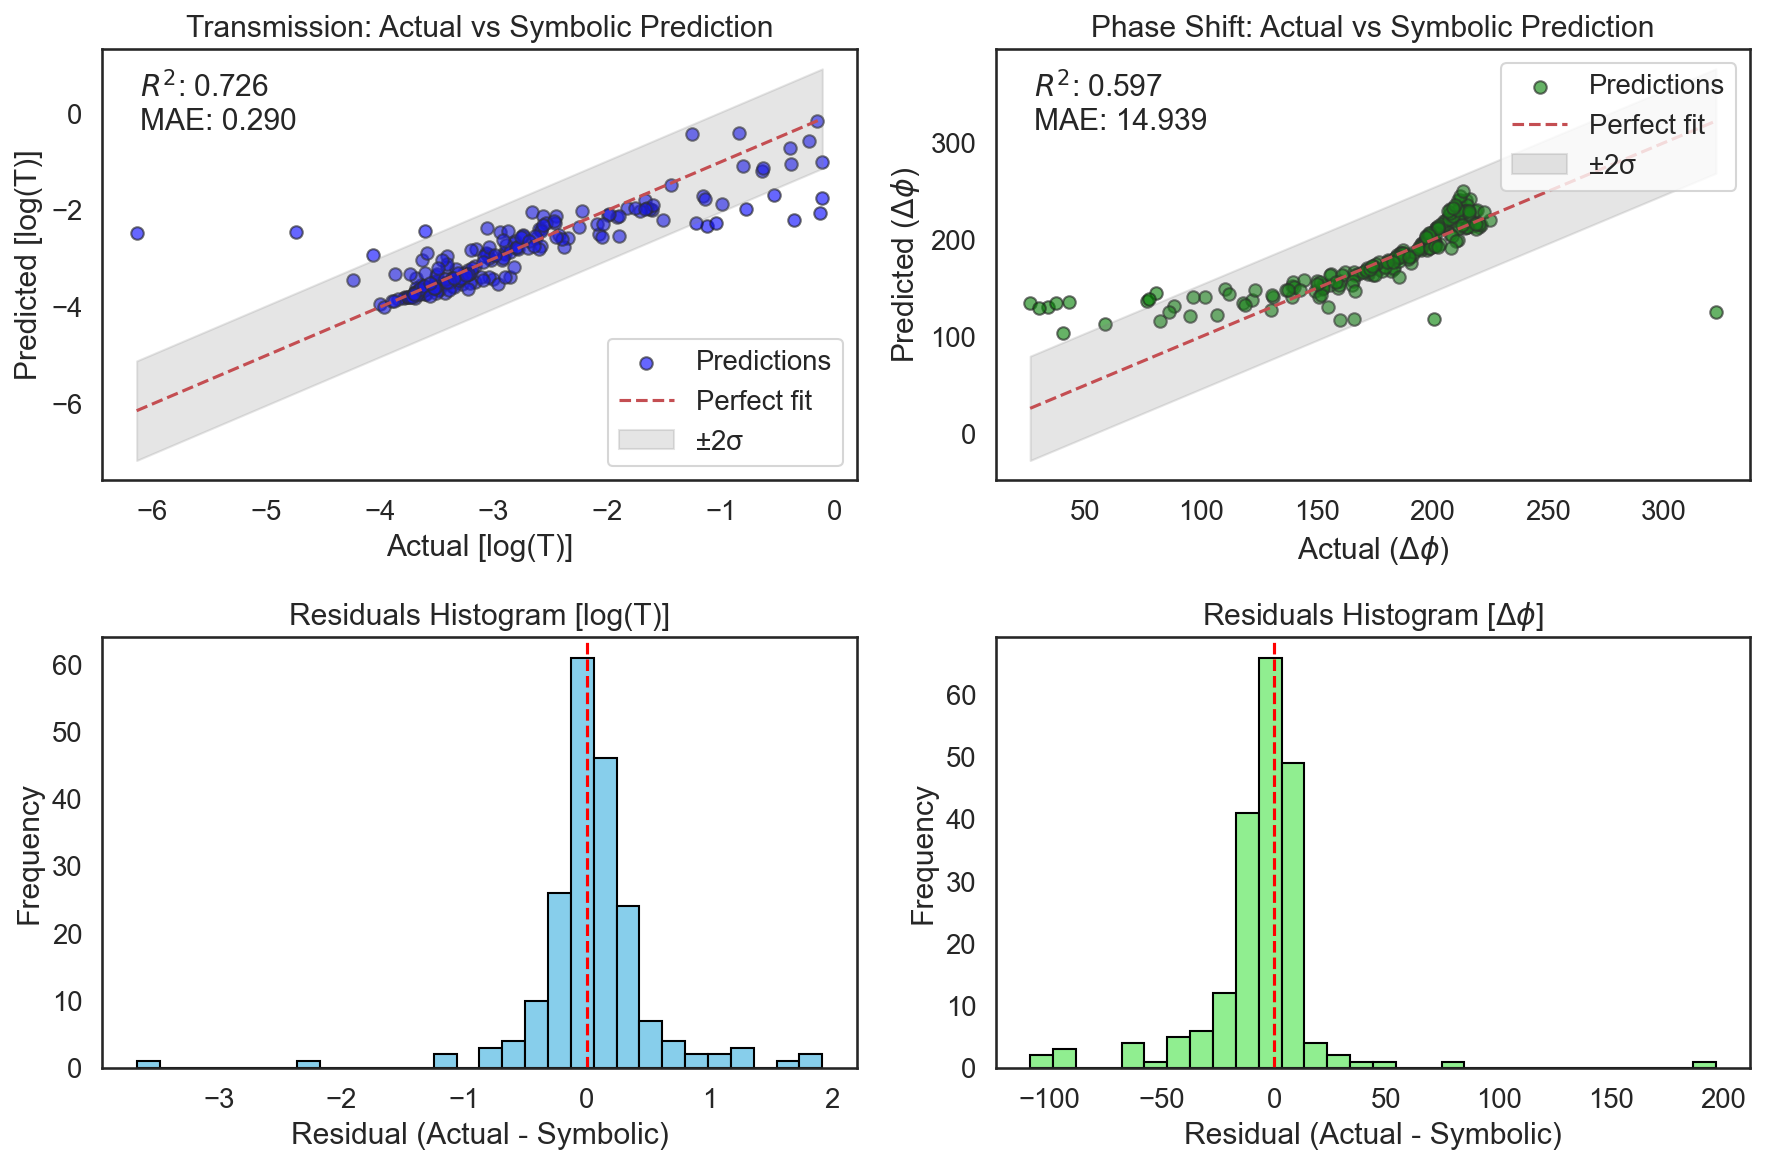

In [53]:
# === Metrics for Transmission ===
r2_T = r2_score(y_test_T, y_pred_T)
mae_T = mean_absolute_error(y_test_T, y_pred_T)
residuals_T = y_test_T - y_pred_T
std_T = np.std(residuals_T)

# === Metrics for Phase Shift ===
r2_P = r2_score(y_test_P, y_pred_P)
mae_P = mean_absolute_error(y_test_P, y_pred_P)
residuals_P = y_test_P - y_pred_P
std_P = np.std(residuals_P)

# === Create Figure (2 rows, 2 columns) ===
fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi=150)

# === Plot 1: Transmission ===
axs[0,0].scatter(y_test_T, y_pred_T, alpha=0.6, edgecolor='k', color='blue', label="Predictions")
line_T = np.linspace(y_test_T.min(), y_test_T.max(), 100)
axs[0,0].plot(line_T, line_T, 'r--', label="Perfect fit")
axs[0,0].fill_between(line_T, line_T - 2*std_T, line_T + 2*std_T, 
                    color='gray', alpha=0.2, label="±2σ")

axs[0,0].set_title("Transmission: Actual vs Symbolic Prediction")
axs[0,0].set_xlabel("Actual [log(T)]")
axs[0,0].set_ylabel("Predicted [log(T)]")
axs[0,0].legend()
axs[0,0].text(
    0.05, 0.95,
    f"$R^2$: {r2_T:.3f}\nMAE: {mae_T:.3f}",
    transform=axs[0,0].transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# === Plot 1b: Residuals Histogram for Transmission ===
axs[1, 0].hist(residuals_T, bins=30, color='skyblue', edgecolor='black')
axs[1, 0].axvline(0, color='red', linestyle='--')
axs[1, 0].set_title("Residuals Histogram [log(T)]")
axs[1, 0].set_xlabel("Residual (Actual - Symbolic)")
axs[1, 0].set_ylabel("Frequency")

# === Plot 2: Phase Shift ===
axs[0,1].scatter(y_test_P, y_pred_P, alpha=0.6, edgecolor='k', color='green', label="Predictions")
line_P = np.linspace(y_test_P.min(), y_test_P.max(), 100)
axs[0,1].plot(line_P, line_P, 'r--', label="Perfect fit")
axs[0,1].fill_between(line_P, line_P - 2*std_P, line_P + 2*std_P, 
                    color='gray', alpha=0.2, label="±2σ")

axs[0,1].set_title("Phase Shift: Actual vs Symbolic Prediction")
axs[0,1].set_xlabel(r"Actual ($\Delta\phi$)")
axs[0,1].set_ylabel(r"Predicted ($\Delta\phi$)")
axs[0,1].legend(loc='upper right')
axs[0,1].text(
    0.05, 0.95,
    f"$R^2$: {r2_P:.3f}\nMAE: {mae_P:.3f}",
    transform=axs[0,1].transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# === Plot 2b: Residuals Histogram for Phase Shift ===
axs[1, 1].hist(residuals_P, bins=30, color='lightgreen', edgecolor='black')
axs[1, 1].axvline(0, color='red', linestyle='--')
axs[1, 1].set_title(r"Residuals Histogram [$\Delta\phi$]")
axs[1, 1].set_xlabel("Residual (Actual - Symbolic)")
axs[1, 1].set_ylabel("Frequency")


# === Final Layout ===
plt.tight_layout()
plt.savefig("symbolic_actual_vs_pred.pdf", format='pdf')
plt.show()